In [1]:
import rasterio
tif_path = r"E:\TreeExtraction\Data_v1\Train_Image.tif"

with rasterio.open(tif_path) as src:
    print("File:", tif_path)
    print("Driver:", src.driver)  
    print("CRS:", src.crs)        
    print("Width (pixels):", src.width)
    print("Height (pixels):", src.height)
    print("Pixel Size:", src.res) 
    print("Number of Bands:", src.count)
    print("Bounds:", src.bounds)  
    print("Data Type:", src.dtypes)
    print("Transform:", src.transform)
    
    for i in range(1, src.count + 1):
        print(f" Band {i}: dtype={src.dtypes[i-1]}, min={src.read(i).min()}, max={src.read(i).max()}")


File: E:\TreeExtraction\Data_v1\Train_Image.tif
Driver: GTiff
CRS: ESRI:54004
Width (pixels): 5296
Height (pixels): 3009
Pixel Size: (0.08556790030251885, 0.08556789631100144)
Number of Bands: 3
Bounds: BoundingBox(left=-19519353.0406, bottom=-2388477.5968, right=-19518899.873, top=-2388220.123)
Data Type: ('uint8', 'uint8', 'uint8')
Transform: | 0.09, 0.00,-19519353.04|
| 0.00,-0.09,-2388220.12|
| 0.00, 0.00, 1.00|
 Band 1: dtype=uint8, min=0, max=255
 Band 2: dtype=uint8, min=0, max=255
 Band 3: dtype=uint8, min=0, max=255


In [1]:
import geopandas as gpd

shp_path = r"E:\TreeExtraction\Data_v1\Traning_Sample_Buffer.shp"
gdf = gpd.read_file(shp_path)

print("File:", shp_path)
print("CRS:", gdf.crs)                    
print("Number of Features:", len(gdf))    
print("Geometry Type:", gdf.geom_type.unique())  
print("Bounds:", gdf.total_bounds)     

print("\nAttribute Fields:")
print(list(gdf.columns))

print("\nFirst row:")
print(gdf.head(1))


File: E:\TreeExtraction\Data_v1\Traning_Sample_Buffer.shp
CRS: PROJCS["World_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54004"]]
Number of Features: 645
Geometry Type: ['Polygon']
Bounds: [-19519355.04801589  -2388479.83524714 -19518920.31025364
  -2388217.74357111]

Attribute Fields:
['osm_id', 'name', 'barrier', 'highway', 'ref', 'address', 'is_in', 'place', 'man_made', 'other_tags', 'geometry']

First row:
       osm_id  name barrier highway   ref address is_in place man_made  \
0  5271769476  None    None    No

C:\Users\subha\AppData\Local\Temp\ipykernel_19572\4185628133.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\subha\AppData\Local\Temp\ipykernel_19572\4185628133.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


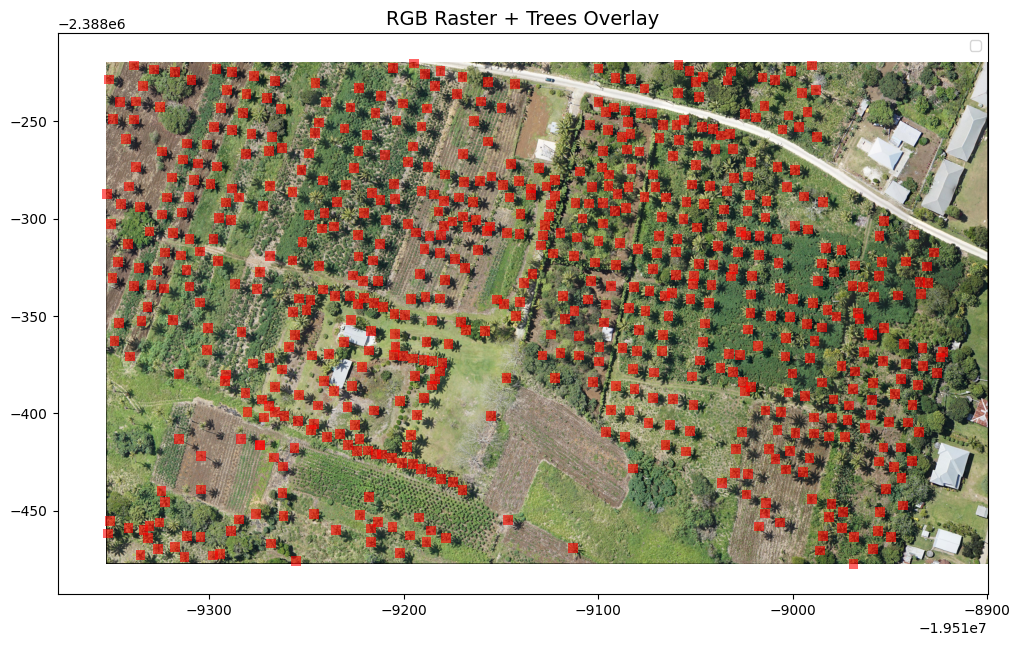

In [7]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd

tif_path = r"E:\TreeExtraction\Data_v1\Train_Image.tif"
shp_path = r"E:\TreeExtraction\Data_v1\Traning_Sample_Buffer.shp"

src = rasterio.open(tif_path)
gdf = gpd.read_file(shp_path)

fig, ax = plt.subplots(figsize=(12, 12))
show((src, [1, 2, 3]), ax=ax)

gdf.plot(ax=ax, marker="o", color="red", markersize=3, alpha=0.6, label="Tree Points")
plt.legend()
plt.title("RGB Raster + Trees Overlay", fontsize=14)
plt.show()


In [3]:
import os
import rasterio
from rasterio.windows import Window
from shapely.geometry import box
import geopandas as gpd
from tqdm import tqdm

big_tif   = r"E:\TreeExtraction\Data_v1\Train_Image.tif"
shp_path  = r"E:\TreeExtraction\Data_v1\Traning_Sample_Buffer.shp"
out_img   = r"E:\TreeExtraction\Data_v1\patches\images"
out_lbl   = r"E:\TreeExtraction\Data_v1\patches\labels"

os.makedirs(out_img, exist_ok=True)
os.makedirs(out_lbl, exist_ok=True)

patch_size = 256
overlap    = 128

gdf = gpd.read_file(shp_path)
with rasterio.open(big_tif) as src:
    gdf = gdf.to_crs(src.crs)

    W, H = src.width, src.height
    def poly_to_yolo(polygon, img_w, img_h, transform):
        minx, miny, maxx, maxy = polygon.bounds
        col_min, row_max = ~transform * (minx, miny)
        col_max, row_min = ~transform * (maxx, maxy)

        col_min, col_max = max(0, col_min), min(img_w, col_max)
        row_min, row_max = max(0, row_min), min(img_h, row_max)

        if col_max <= col_min or row_max <= row_min:
            return None

        x_center = ((col_min + col_max) / 2) / img_w
        y_center = ((row_min + row_max) / 2) / img_h
        w = (col_max - col_min) / img_w
        h = (row_max - row_min) / img_h
        return [0, x_center, y_center, w, h]

    step = patch_size - overlap
    counter = 0        # total patches
    label_counter = 0  # patches with labels

    for i in tqdm(range(0, W, step)):
        for j in range(0, H, step):
            if i + patch_size > W or j + patch_size > H:
                continue

            window = Window(i, j, patch_size, patch_size)
            transform = src.window_transform(window)
            patch_bounds = box(*rasterio.windows.bounds(window, transform=src.transform))

            sub_gdf = gdf[gdf.intersects(patch_bounds)]
            if len(sub_gdf) == 0:
                continue

            patch_img = src.read(window=window)

            patch_name = f"image_{counter:03d}.tif"
            img_path = os.path.join(out_img, patch_name)
            profile = src.profile
            profile.update({
                "height": patch_size,
                "width": patch_size,
                "transform": transform
            })
            with rasterio.open(img_path, "w", **profile) as dst:
                dst.write(patch_img)

            yolo_lines = []
            for geom in sub_gdf.geometry:
                yolo_box = poly_to_yolo(geom, patch_size, patch_size, transform)
                if yolo_box:
                    yolo_lines.append(" ".join(map(str, yolo_box)))

            if len(yolo_lines) > 0:
                label_path = os.path.join(out_lbl, patch_name.replace(".tif", ".txt"))
                with open(label_path, "w") as f:
                    f.write("\n".join(yolo_lines))
                label_counter += 1

            counter += 1

print(f"✅ Total patches created: {counter}")
print(f"✅ Patches with labels:   {label_counter}")

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:04<00:00,  1.54s/it]

✅ Total patches created: 772
✅ Patches with labels:   772


In [1]:
import os
from glob import glob

patch_dir = r"E:\TreeExtraction\Data_v1\patches\images"
label_dir = r"E:\TreeExtraction\Data_v1\patches\labels"

patches = sorted(glob(os.path.join(patch_dir, "*.tif")))

print(f"🔎 Found {len(patches)} patch images")
if len(patches) < 5:
    print("❌ Not enough patches, stopping...")
else:
    print("✅ Enough patches found, proceeding...")

labels = sorted(glob(os.path.join(label_dir, "*.txt")))
print(f"🔎 Found {len(labels)} label files")


🔎 Found 772 patch images
✅ Enough patches found, proceeding...
🔎 Found 772 label files


In [3]:
import os
import random
import shutil

IMAGE_DIR = r"E:\TreeExtraction\Data_v1\patches\images"  
LABEL_DIR = r"E:\TreeExtraction\Data_v1\patches\labels"
YOLO_DIR = r"E:\TreeExtraction\Data_v1\yolo_data"

IMG_DIR = os.path.join(YOLO_DIR, "images")
LBL_DIR = os.path.join(YOLO_DIR, "labels")
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(LBL_DIR, exist_ok=True)

patch_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".tif")]
print(f"🔎 Found {len(patch_files)} patch images")

count_with_labels = 0

for patch_name in patch_files:
    patch_path = os.path.join(IMAGE_DIR, patch_name)
    lbl_file = patch_name.replace(".tif", ".txt")
    lbl_path = os.path.join(LABEL_DIR, lbl_file)
    
    shutil.copy(patch_path, os.path.join(IMG_DIR, patch_name))

    if os.path.exists(lbl_path):
        shutil.copy(lbl_path, os.path.join(LBL_DIR, lbl_file))
        count_with_labels += 1

print(f"✅ Copied {count_with_labels} images with labels to YOLO folder")

all_images = [f for f in os.listdir(IMG_DIR) if f.endswith(".tif")]
random.shuffle(all_images)

train_split = int(0.7 * len(all_images))
val_split = int(0.9 * len(all_images))

splits = {
    "train": all_images[:train_split],
    "val": all_images[train_split:val_split],
    "test": all_images[val_split:],
}

for split, files in splits.items():
    split_img_dir = os.path.join(YOLO_DIR, split, "images")
    split_lbl_dir = os.path.join(YOLO_DIR, split, "labels")
    os.makedirs(split_img_dir, exist_ok=True)
    os.makedirs(split_lbl_dir, exist_ok=True)

    for f in files:
        shutil.move(os.path.join(IMG_DIR, f), os.path.join(split_img_dir, f))
        lbl_file = f.replace(".tif", ".txt")
        if os.path.exists(os.path.join(LBL_DIR, lbl_file)):
            shutil.move(os.path.join(LBL_DIR, lbl_file), os.path.join(split_lbl_dir, lbl_file))

print("✅ Dataset split into Train/Val/Test")

yaml_content = f"""
train: {os.path.join(YOLO_DIR, 'train')}
val: {os.path.join(YOLO_DIR, 'val')}
test: {os.path.join(YOLO_DIR, 'test')}

nc: 1
names: ['coconut_tree']
"""

with open(os.path.join(YOLO_DIR, "data.yaml"), "w") as f:
    f.write(yaml_content)

print("✅ data.yaml file created")


🔎 Found 772 patch images
✅ Copied 772 images with labels to YOLO folder
✅ Dataset split into Train/Val/Test
✅ data.yaml file created


In [1]:
import os
from ultralytics import YOLO

DATA_DIR = r"E:\TreeExtraction\Data_v1\yolo_data"   
DATA_YAML = os.path.join(DATA_DIR, "data.yaml")     
SAVE_DIR = os.path.join(DATA_DIR, "runs")          
os.makedirs(SAVE_DIR, exist_ok=True)

model = YOLO("yolo11n.yaml")

# === Train model ===
model.train(
    data=DATA_YAML,
    epochs=2000,
    imgsz=256,
    batch=32,             
    device=0,
    workers=8,
    optimizer="AdamW",
    patience=0,
    lr0=0.0001,
    pretrained=False,
    save=True,
    save_period=10,
    val=True,
    project=SAVE_DIR,
    name="yolov11_scratch"
)

metrics = model.val(data=DATA_YAML, imgsz=256, device=0)
print("Final Evaluation Metrics:", metrics)


New https://pypi.org/project/ultralytics/8.3.186 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.185  Python-3.10.16 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=E:\TreeExtraction\Data_v1\yolo_data\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2000, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11_scratch, nb

train: Scanning E:\TreeExtraction\Data_v1\yolo_data\train\labels.cache... 540 images, 0 backgrounds, 0 corrupt: 100%|██


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.1 ms, read: 514.5191.3 MB/s, size: 194.0 KB)


val: Scanning E:\TreeExtraction\Data_v1\yolo_data\val\labels.cache... 154 images, 0 backgrounds, 0 corrupt: 100%|██████


Plotting labels to E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch
Starting training for 2000 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     1/2000      1.34G       4.41      2.984      3.281        212        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757    0.00364      0.222    0.00235   0.000639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     2/2000      1.74G      3.779      2.643      2.766        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757     0.0092      0.561    0.00737    0.00165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     3/2000      1.76G      3.698      2.551      2.589        150        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757     0.0106      0.647     0.0114    0.00373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     4/2000      1.78G       3.54      2.491      2.526        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757     0.0108      0.657      0.016    0.00549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     5/2000      1.79G      3.392      2.401      2.458        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757     0.0106      0.646      0.023    0.00798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     6/2000      1.81G      3.364      2.368      2.446        216        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757     0.0104      0.635     0.0384      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     7/2000      1.82G      3.301      2.316      2.412        203        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757     0.0105      0.641     0.0677     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     8/2000      1.84G       3.28      2.303       2.41        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757     0.0104      0.634      0.109     0.0388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     9/2000      1.84G      3.191      2.271      2.376        226        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.251      0.263      0.149     0.0543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    10/2000      1.84G      3.091      2.247       2.34        172        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.281      0.297      0.177     0.0598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    11/2000      1.84G      3.094      2.193      2.324        222        256: 100%|██████████| 17/17 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.328       0.32      0.226     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    12/2000      1.84G       2.99      2.164      2.254        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.362      0.359       0.26     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    13/2000      1.84G      3.003      2.154      2.256        238        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.353      0.354      0.253     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    14/2000      1.84G      2.893      2.123      2.227        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.37      0.347      0.255     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    15/2000      1.84G      2.913      2.098      2.236        157        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.365      0.334      0.257     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    16/2000      1.84G      2.868      2.064      2.194        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.413      0.354      0.286     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    17/2000      1.84G      2.819      2.052      2.164        194        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.439      0.369      0.311      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    18/2000      1.84G      2.773      1.977      2.159        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.469      0.393      0.334      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    19/2000      1.84G      2.773      1.998      2.138        171        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.419      0.353      0.296     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    20/2000      1.84G      2.724      1.952      2.098        205        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.375      0.305      0.235     0.0547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    21/2000      1.84G      2.757      1.917      2.103        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.359      0.267      0.214     0.0438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    22/2000      1.84G       2.71      1.908      2.089        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.453      0.357      0.308     0.0756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    23/2000      1.84G      2.711      1.885      2.103        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.59      0.436      0.418      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    24/2000      1.84G      2.643      1.847      2.063        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.539      0.399      0.383     0.0983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    25/2000      1.84G      2.652      1.841      2.054        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.621      0.419      0.425      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    26/2000      1.84G      2.606      1.792      2.034        172        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.619      0.439      0.431      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    27/2000      1.84G      2.568      1.786      1.997        205        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.646      0.449      0.439      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    28/2000      1.84G      2.505      1.742      1.991        155        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.685       0.46      0.467      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    29/2000      1.84G      2.586      1.751      2.008        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.668      0.462      0.472      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    30/2000      1.85G      2.541      1.724      1.968        225        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.74      0.482      0.503      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    31/2000      1.85G      2.533      1.705       1.99        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.712      0.481       0.49      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    32/2000      1.85G      2.551      1.707      1.956        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.73      0.491       0.51      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    33/2000      1.85G      2.489       1.69      1.944        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.722      0.501      0.525      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    34/2000      1.85G      2.463      1.635      1.923        185        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.705      0.498      0.514      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    35/2000      1.85G      2.467      1.644      1.925        163        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.665      0.481      0.474      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    36/2000      1.85G       2.45      1.597      1.911        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.712      0.522       0.54      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    37/2000      1.85G      2.448      1.585      1.923        168        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.736      0.539      0.562      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    38/2000      1.85G      2.414      1.572        1.9        201        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.742      0.538      0.567      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    39/2000      1.85G      2.437      1.573      1.915        180        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.711      0.519      0.532      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    40/2000      1.85G       2.42      1.569      1.894        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.731      0.557      0.568      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    41/2000      1.85G      2.381      1.538      1.884        185        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.749      0.559      0.568      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    42/2000      1.85G      2.384       1.51      1.875        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.763      0.542      0.577      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    43/2000      1.85G      2.344      1.493      1.844        178        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.756      0.543      0.571      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    44/2000      1.85G      2.337      1.499      1.835        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.71      0.539      0.537      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    45/2000      1.85G      2.332      1.474      1.837        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.712      0.535      0.532      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    46/2000      1.85G      2.398       1.53      1.865        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.716      0.538      0.533      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    47/2000      1.85G      2.336      1.511      1.837        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.739      0.581      0.585      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    48/2000      1.85G      2.325      1.481      1.837        225        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.751      0.561      0.566      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    49/2000      1.85G      2.305      1.472      1.815        183        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.759      0.569      0.583      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    50/2000      1.85G      2.306      1.451      1.803        200        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.761      0.576      0.583      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    51/2000      1.85G      2.255      1.437      1.791        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.771      0.575      0.591      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    52/2000      1.85G      2.261      1.444      1.814        161        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.746      0.589      0.594      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    53/2000      1.85G      2.281      1.448      1.811        177        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.752      0.581      0.591       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    54/2000      1.85G      2.268       1.43      1.791        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.734      0.554      0.562      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    55/2000      1.85G      2.237      1.418      1.779        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.752      0.588        0.6      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    56/2000      1.85G      2.253       1.41      1.775        158        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.743      0.567      0.573      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    57/2000      1.85G      2.285      1.443      1.813        161        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.742      0.596      0.591      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    58/2000      1.85G      2.225      1.408      1.768        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.756      0.598      0.597      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    59/2000      1.85G      2.288      1.403      1.798        151        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.748      0.611      0.599      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    60/2000      1.85G      2.227      1.383      1.764        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.751      0.608      0.597      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    61/2000      1.85G      2.205      1.365      1.752        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.757        0.6       0.59      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    62/2000      1.85G      2.206      1.368      1.757        241        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.753      0.613      0.603      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    63/2000      1.85G      2.183       1.36      1.738        174        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.727      0.593      0.591      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    64/2000      1.85G      2.187      1.363      1.745        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.753      0.614      0.609      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    65/2000      1.85G      2.222      1.403      1.777        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.749      0.608      0.615      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    66/2000      1.85G      2.149      1.347      1.718        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.757      0.614      0.621      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    67/2000      1.85G      2.152       1.33      1.698        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.764      0.612      0.618      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    68/2000      1.85G       2.22      1.383      1.752        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.775      0.606      0.619      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    69/2000      1.85G      2.139      1.333      1.708        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.784      0.601      0.611      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    70/2000      1.85G      2.137       1.32        1.7        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.755      0.617      0.614      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    71/2000      1.85G      2.157      1.356      1.749        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.787      0.606      0.628      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    72/2000      1.85G      2.159      1.318      1.726        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.78      0.614      0.625      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    73/2000      1.85G      2.173      1.341      1.731        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.709      0.576      0.537      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    74/2000      1.85G      2.126        1.3      1.707        173        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.76       0.62      0.617      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    75/2000      1.85G        2.1      1.293      1.675        166        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.741       0.61      0.598        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    76/2000      1.85G      2.119      1.299       1.69        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.781      0.623      0.637      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    77/2000      1.85G      2.169      1.307      1.723        207        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.754      0.627      0.623      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    78/2000      1.85G      2.134      1.313      1.715        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.758      0.639      0.634      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    79/2000      1.85G      2.078      1.274      1.679        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.768      0.631      0.624      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    80/2000      1.85G      2.107      1.288      1.694        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.77      0.633      0.627      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    81/2000      1.85G      2.116      1.295       1.69        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.776      0.631      0.636      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    82/2000      1.85G      2.098      1.282      1.667        227        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.763      0.621      0.616      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    83/2000      1.85G       2.09      1.254      1.664        225        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.769      0.648      0.648       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    84/2000      1.85G      2.074      1.285      1.661        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.777      0.631      0.637      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    85/2000      1.85G      2.107      1.277      1.675        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.787      0.638      0.653      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    86/2000      1.85G      2.104      1.298      1.679        190        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.777      0.621       0.62      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    87/2000      1.85G      2.078      1.267      1.653        213        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.784      0.634      0.644      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    88/2000      1.85G       2.12      1.296       1.69        177        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.785      0.627      0.643      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    89/2000      1.85G       2.07      1.273      1.655        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.789      0.618      0.638      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    90/2000      1.85G      2.072      1.255      1.662        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.782      0.634      0.651      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    91/2000      1.85G      2.078      1.247      1.662        157        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.778       0.63       0.64      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    92/2000      1.85G      2.089      1.258      1.689        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.779      0.647      0.653      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    93/2000      1.85G      2.017      1.227      1.648        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.789      0.626      0.643      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    94/2000      1.85G      2.047      1.248      1.662        159        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.796      0.643      0.666      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    95/2000      1.85G      2.065      1.252      1.648        243        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.781      0.633      0.636      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    96/2000      1.85G      2.092      1.282      1.676        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.791      0.642      0.661      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    97/2000      1.85G      2.055      1.239      1.649        168        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.749      0.627      0.617      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    98/2000      1.85G      2.038      1.229      1.631        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.766      0.635      0.624      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    99/2000      1.85G      2.054      1.229      1.652        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.783      0.648      0.651      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   100/2000      1.85G      2.036      1.233      1.637        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.786      0.657      0.657      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   101/2000      1.85G      2.029      1.229      1.631        174        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.786      0.655      0.657      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   102/2000      1.85G       2.03      1.242      1.651        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.795      0.661      0.672      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   103/2000      1.85G      2.063      1.245      1.645        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.806      0.655      0.671      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   104/2000      1.85G      2.038      1.224      1.637        167        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.654      0.679      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   105/2000      1.85G      2.019      1.223       1.63        167        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.643      0.673      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   106/2000      1.85G      2.016      1.204      1.632        203        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.647      0.668      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   107/2000      1.85G      2.042      1.213      1.644        178        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.657      0.681      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   108/2000      1.85G      1.998      1.203      1.633        217        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.654      0.683      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   109/2000      1.85G      1.999      1.181      1.618        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.809      0.643       0.67      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   110/2000      1.85G      1.979      1.191      1.612        189        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.778      0.643      0.646      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   111/2000      1.85G      2.007      1.198      1.612        188        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.778      0.635      0.646      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   112/2000      1.85G      1.975      1.195      1.595        196        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.802      0.649      0.666      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   113/2000      1.85G      1.982      1.202      1.619        165        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.813      0.645      0.659      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   114/2000      1.85G      1.974       1.17      1.597        228        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.796      0.647      0.663      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   115/2000      1.85G      1.969      1.185      1.593        171        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<0

                   all        154        757      0.775       0.62      0.626      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   116/2000      1.85G      1.986      1.182      1.609        257        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.823      0.655      0.674      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   117/2000      1.85G      1.966      1.165      1.602        193        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.816      0.657      0.674      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   118/2000      1.85G      2.014      1.184      1.619        146        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.786      0.629      0.645      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   119/2000      1.85G      1.951      1.179      1.595        165        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.801      0.642      0.668      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   120/2000      1.85G      1.996       1.19      1.607        158        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.812      0.659      0.683      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   121/2000      1.85G      1.997      1.182      1.631        138        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.807      0.663      0.685      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   122/2000      1.85G      1.992      1.155      1.595        175        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.795      0.658      0.674      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   123/2000      1.85G      1.954      1.163      1.585        199        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757        0.8      0.662      0.683      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   124/2000      1.85G       1.95      1.147      1.573        219        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757       0.82      0.661      0.683      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   125/2000      1.85G      1.957      1.143      1.577        189        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.808      0.649      0.674      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   126/2000      1.85G      1.966      1.153      1.584        189        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.819      0.659      0.684      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   127/2000      1.87G      1.969      1.161      1.606        181        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.796      0.651      0.664      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   128/2000      1.87G      1.941      1.156      1.585        194        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.666      0.688      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   129/2000      1.87G      1.925      1.134      1.576        205        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.664      0.686      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   130/2000      1.87G      1.968      1.158      1.603        142        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.671      0.697      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   131/2000      1.87G      1.937      1.126      1.592        201        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832       0.67      0.701      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   132/2000      1.87G      1.913       1.13      1.562        196        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.667       0.69       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   133/2000      1.87G      1.913      1.118      1.549        197        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828      0.669      0.702      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   134/2000      1.87G      1.936      1.138      1.557        172        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821       0.67      0.689      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   135/2000      1.87G      1.938      1.143      1.576        165        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825      0.671      0.697      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   136/2000      1.87G      1.927      1.154      1.576        175        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82       0.66      0.693      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   137/2000      1.87G       1.92       1.12      1.566        183        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82      0.673      0.695      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   138/2000      1.87G      1.889      1.118      1.531        157        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.804      0.654      0.676      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   139/2000      1.87G      1.942      1.143      1.567        170        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.808      0.671      0.694      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   140/2000      1.87G      1.921      1.144      1.577        170        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.809      0.677      0.703      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   141/2000      1.87G      1.915      1.141      1.555        208        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.791      0.651      0.678       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   142/2000      1.87G      1.918      1.134      1.555        173        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.799      0.678      0.704      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   143/2000      1.87G      1.926      1.128      1.573        169        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.803      0.679      0.697      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   144/2000      1.87G      1.929       1.14       1.57        180        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.822      0.675      0.705      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   145/2000      1.87G      1.892      1.121       1.55        176        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.813      0.676      0.708      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   146/2000      1.87G      1.889      1.102      1.542        205        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.782      0.679      0.682      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   147/2000      1.87G      1.904      1.115      1.542        208        256: 100%|██████████| 17/17 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.785       0.68      0.692      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   148/2000      1.87G      1.914      1.123      1.542        205        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.805      0.675      0.706      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   149/2000      1.87G      1.885      1.111      1.537        162        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.813       0.67      0.705      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   150/2000      1.87G      1.927      1.141      1.592        146        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.815      0.676      0.707      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   151/2000      1.87G      1.939      1.141      1.592        187        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.809      0.681      0.711      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   152/2000      1.87G      1.901      1.141      1.562        162        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.788      0.661      0.677      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   153/2000      1.87G      1.906      1.121       1.55        201        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.667      0.695       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   154/2000      1.87G      1.876      1.099      1.536        188        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.791      0.674      0.693       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   155/2000      1.87G      1.886      1.124      1.539        208        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.802      0.684      0.709      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   156/2000      1.87G      1.881       1.11      1.535        197        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.807      0.691      0.711      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   157/2000      1.87G      1.902      1.122      1.551        192        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.683      0.719      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   158/2000      1.87G      1.867      1.103      1.539        206        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.685      0.721       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   159/2000      1.87G      1.842      1.112      1.516        182        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.806       0.67      0.707       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   160/2000      1.87G      1.909      1.119      1.547        191        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.806      0.684      0.719      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   161/2000      1.87G      1.899      1.116      1.539        167        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.671      0.707       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   162/2000      1.87G      1.869        1.1      1.532        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.687      0.718      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   163/2000      1.87G      1.856      1.088      1.529        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.684      0.717      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   164/2000      1.87G      1.927      1.126      1.574        187        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.682      0.719      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   165/2000      1.87G      1.891      1.091       1.55        219        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.829      0.674       0.72      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   166/2000      1.87G      1.864      1.097      1.543        197        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.808      0.683      0.704      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   167/2000      1.87G      1.888      1.102      1.551        171        256: 100%|██████████| 17/17 [00:14<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.813      0.686      0.713      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   168/2000      1.87G      1.869      1.104      1.543        223        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757       0.82      0.688      0.727      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   169/2000      1.87G       1.87      1.093      1.535        191        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757       0.82      0.686      0.717      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   170/2000      1.87G      1.841      1.094      1.534        190        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.826      0.682      0.731      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   171/2000      1.87G      1.873      1.095       1.52        169        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.822      0.672      0.716      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   172/2000      1.87G      1.878      1.098      1.526        188        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<0

                   all        154        757      0.826      0.691       0.73      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   173/2000      1.87G      1.899      1.096       1.56        153        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.817      0.684      0.722      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   174/2000      1.87G      1.847      1.081      1.514        182        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.822      0.678      0.713      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   175/2000      1.87G      1.862       1.08      1.524        210        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.825      0.675      0.713      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   176/2000      1.87G      1.847      1.085      1.517        207        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.821      0.674      0.713      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   177/2000      1.87G      1.844      1.089      1.512        188        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.674       0.72       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   178/2000      1.87G      1.845      1.081      1.503        173        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.679       0.72       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   179/2000      1.87G      1.889      1.098      1.543        171        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.837      0.679      0.731      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   180/2000      1.87G      1.899      1.088      1.547        204        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.682      0.724      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   181/2000      1.87G      1.838      1.081      1.514        174        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.815      0.694       0.73      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   182/2000      1.87G      1.881      1.092      1.542        197        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828       0.68      0.734      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   183/2000      1.87G      1.847      1.062      1.521        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.809      0.688      0.726      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   184/2000      1.87G      1.834      1.094      1.528        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.687      0.732      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   185/2000      1.87G      1.832      1.055      1.507        210        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.687      0.728      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   186/2000      1.87G      1.813      1.063      1.483        179        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.694      0.723      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   187/2000      1.87G      1.809      1.072      1.492        169        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82      0.702      0.736      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   188/2000      1.87G      1.824      1.072      1.496        180        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.691      0.723      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   189/2000      1.87G      1.802      1.061      1.496        184        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.699      0.735      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   190/2000      1.87G      1.858      1.082       1.54        174        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.794      0.715      0.729      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   191/2000      1.87G      1.822      1.096      1.517        170        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.793      0.713      0.729      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   192/2000      1.87G      1.798      1.056      1.486        195        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.804      0.705      0.733      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   193/2000      1.87G      1.806       1.05      1.508        168        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.793      0.717      0.736      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   194/2000      1.87G       1.85      1.079      1.534        161        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.796      0.711      0.739      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   195/2000      1.87G      1.839      1.072      1.514        184        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.813        0.7      0.738      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   196/2000      1.87G      1.826      1.075      1.494        203        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757       0.81        0.7      0.727      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   197/2000      1.87G      1.823      1.059       1.51        207        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.807      0.707      0.733      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   198/2000      1.87G      1.805      1.069       1.51        157        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.794      0.703      0.736      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   199/2000      1.87G      1.836      1.067      1.499        178        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.816        0.7      0.736      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   200/2000      1.87G      1.881      1.107      1.536        188        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757       0.82      0.697      0.744      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   201/2000      1.87G      1.848      1.095      1.524        163        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.814       0.69      0.723      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   202/2000      1.87G      1.798      1.053      1.496        186        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.811      0.705      0.736      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   203/2000      1.87G      1.819      1.061      1.508        181        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.711       0.74      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   204/2000      1.87G      1.821      1.053      1.505        152        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83        0.7      0.744      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   205/2000      1.87G      1.815      1.055      1.511        222        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.704      0.744      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   206/2000      1.87G      1.816      1.067      1.503        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.695      0.739      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   207/2000      1.87G      1.795      1.045      1.495        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.696      0.743       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   208/2000      1.87G      1.792      1.062      1.488        174        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.826      0.691      0.732      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   209/2000      1.87G      1.815      1.049      1.508        184        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.703      0.741      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   210/2000      1.87G      1.795      1.054       1.49        149        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.698      0.741      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   211/2000      1.87G      1.821      1.064      1.512        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821        0.7      0.741      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   212/2000      1.87G      1.789      1.056      1.491        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.701      0.739      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   213/2000      1.87G      1.791      1.036      1.476        219        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.806      0.707      0.738      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   214/2000      1.87G       1.81      1.059      1.493        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.808      0.717       0.74      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   215/2000      1.87G      1.806      1.063      1.493        147        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.713      0.745      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   216/2000      1.87G      1.787      1.053      1.478        155        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.801      0.711      0.741      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   217/2000      1.87G      1.804      1.044      1.501        216        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.793      0.717      0.747       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   218/2000      1.87G      1.817      1.051      1.499        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.802      0.696      0.732      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   219/2000      1.87G      1.779      1.034      1.471        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825        0.7      0.743      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   220/2000      1.87G      1.788      1.046      1.487        225        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829       0.69      0.741      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   221/2000      1.87G      1.749      1.033      1.466        176        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.814        0.7      0.737      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   222/2000      1.87G       1.78       1.04      1.478        202        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.799      0.696      0.727      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   223/2000      1.87G      1.793      1.046      1.492        199        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.809      0.706      0.744       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   224/2000      1.87G      1.755      1.037      1.472        189        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.807      0.713      0.746      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   225/2000      1.87G      1.787      1.043      1.485        209        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.815      0.723      0.748      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   226/2000      1.87G      1.774      1.037      1.479        179        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.816       0.71      0.741       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   227/2000      1.87G      1.775      1.035      1.469        154        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.812      0.721      0.748      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   228/2000      1.87G      1.799      1.039      1.475        165        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.788      0.721      0.737      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   229/2000      1.87G      1.799      1.036      1.469        209        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.811      0.712      0.743      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   230/2000      1.87G      1.779      1.027      1.492        197        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.807      0.713      0.741      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   231/2000      1.87G      1.769      1.026      1.471        176        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.812      0.719       0.75      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   232/2000      1.87G      1.812      1.059      1.496        187        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.809      0.718      0.748      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   233/2000      1.87G      1.777      1.048      1.465        222        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.707       0.74      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   234/2000      1.87G      1.752      1.043      1.453        229        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.703      0.741      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   235/2000      1.87G      1.748      1.047      1.461        157        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.721      0.747      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   236/2000      1.87G      1.718      1.014      1.452        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.738      0.752      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   237/2000      1.87G      1.768      1.019       1.47        244        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.714      0.752      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   238/2000      1.87G      1.818      1.049        1.5        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.799       0.71       0.74      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   239/2000      1.87G      1.767       1.03      1.471        181        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.809       0.72      0.756      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   240/2000      1.87G      1.775      1.022      1.475        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.732      0.759      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   241/2000      1.87G       1.78      1.028      1.494        187        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.795       0.74      0.752      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   242/2000      1.87G      1.796      1.033      1.491        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.715      0.753      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   243/2000      1.87G      1.813      1.035      1.482        155        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.699      0.752      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   244/2000      1.87G      1.769      1.034      1.486        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.711      0.745      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   245/2000      1.87G       1.77      1.029      1.461        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.788      0.729      0.743      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   246/2000      1.87G      1.729      1.004      1.446        222        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.784      0.735      0.747      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   247/2000      1.87G      1.751      1.013      1.461        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.778      0.729      0.751      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   248/2000      1.87G      1.734      1.017      1.452        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.801      0.728      0.755      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   249/2000      1.87G      1.719      1.006      1.453        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.797      0.725      0.746      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   250/2000      1.87G      1.772      1.032      1.477        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825      0.709      0.752      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   251/2000      1.87G      1.729      1.029      1.458        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.833        0.7       0.75      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   252/2000      1.87G      1.744      1.032      1.458        185        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<0

                   all        154        757      0.814      0.703      0.737      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   253/2000      1.87G       1.76      1.023      1.453        180        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.814        0.7      0.745      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   254/2000      1.87G      1.737      1.017      1.457        186        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.799      0.712      0.742      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   255/2000      1.87G      1.702     0.9922      1.425        215        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.818      0.707      0.748      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   256/2000      1.87G      1.773     0.9971       1.46        203        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757       0.81      0.707      0.744      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   257/2000      1.87G      1.718     0.9977      1.447        209        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.792      0.721      0.744      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   258/2000      1.87G      1.685     0.9904      1.418        199        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.787      0.717      0.742      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   259/2000      1.87G      1.716      1.012      1.439        232        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.833      0.701      0.753      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   260/2000      1.87G      1.722      1.004      1.447        174        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.835      0.697      0.752      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   261/2000      1.87G      1.774      1.021      1.481        180        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.843      0.697      0.749      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   262/2000      1.87G      1.766      1.027      1.466        169        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.838      0.697      0.748      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   263/2000      1.87G      1.718     0.9968       1.45        152        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.845      0.701      0.752       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   264/2000      1.87G      1.731     0.9986       1.44        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826       0.71      0.741      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   265/2000      1.87G      1.739      1.001      1.448        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.723       0.75      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   266/2000      1.87G      1.743      1.014      1.474        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.81      0.727      0.754      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   267/2000      1.87G       1.72     0.9878      1.433        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.723      0.755      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   268/2000      1.87G      1.731     0.9742      1.417        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.719      0.751      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   269/2000      1.87G      1.682     0.9874       1.42        166        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.714      0.747      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   270/2000      1.87G      1.727      1.018      1.445        172        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.842      0.704       0.75       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   271/2000      1.87G      1.704     0.9934      1.441        175        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.725      0.755      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   272/2000      1.87G      1.711     0.9875       1.44        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813       0.72      0.751      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   273/2000      1.87G       1.72     0.9976      1.441        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812       0.72      0.752      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   274/2000      1.87G      1.706      0.983      1.421        216        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.802      0.731      0.747      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   275/2000      1.87G      1.704     0.9916      1.442        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.737      0.759      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   276/2000      1.87G      1.723      1.002      1.443        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.806      0.731       0.75      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   277/2000      1.87G      1.719      1.011      1.456        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.805      0.738      0.757      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   278/2000      1.87G      1.718      1.012      1.442        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.721      0.763      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   279/2000      1.87G      1.701     0.9998      1.437        147        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.711      0.752      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   280/2000      1.87G      1.711      0.998      1.432        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.798      0.723      0.739        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   281/2000      1.87G        1.7      1.003      1.426        215        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.809      0.738       0.75      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   282/2000      1.87G      1.695     0.9946      1.431        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.799      0.725      0.749      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   283/2000      1.87G      1.703     0.9852      1.432        214        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<0

                   all        154        757      0.815      0.716      0.758      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   284/2000      1.87G      1.725     0.9993       1.44        203        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.817      0.712      0.754      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   285/2000      1.87G      1.743       1.01      1.461        183        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.814      0.711      0.753      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   286/2000      1.87G      1.707     0.9825      1.435        220        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.813      0.712      0.746      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   287/2000      1.87G      1.693     0.9951      1.423        174        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.825      0.708      0.755      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   288/2000      1.87G      1.708     0.9866      1.435        185        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.814      0.717      0.757       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   289/2000      1.87G      1.684     0.9956      1.415        213        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.815       0.72      0.749       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   290/2000      1.87G      1.709     0.9893      1.423        147        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.817      0.728      0.751      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   291/2000      1.87G      1.696     0.9896      1.427        206        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.815      0.729      0.747      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   292/2000      1.87G      1.684      1.002       1.43        188        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.803      0.729      0.735      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   293/2000      1.87G      1.727     0.9927      1.448        147        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.815      0.731       0.76      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   294/2000      1.87G      1.669     0.9585      1.403        158        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.817      0.723      0.758      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   295/2000      1.87G       1.71     0.9802      1.458        198        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.807      0.741      0.765      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   296/2000      1.87G       1.69     0.9868      1.414        168        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.798      0.741       0.75      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   297/2000      1.87G      1.688     0.9885      1.441        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.797      0.741      0.759      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   298/2000      1.87G      1.672     0.9763      1.414        199        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.802      0.744      0.761       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   299/2000      1.87G      1.751     0.9921      1.446        186        256: 100%|██████████| 17/17 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.809      0.738       0.76      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   300/2000      1.87G      1.721     0.9895      1.449        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.801      0.732      0.751      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   301/2000      1.87G      1.688     0.9871      1.414        191        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<0

                   all        154        757      0.796       0.74      0.758      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   302/2000      1.87G      1.671     0.9695      1.416        163        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.736       0.76      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   303/2000      1.87G      1.682     0.9643      1.413        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.738      0.761      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   304/2000      1.87G      1.704      1.009      1.454        155        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.738      0.764      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   305/2000      1.87G      1.668     0.9635       1.39        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.808      0.724      0.754      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   306/2000      1.87G       1.72     0.9911      1.444        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.802      0.742      0.759      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   307/2000      1.87G      1.668     0.9619      1.405        159        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.795      0.736      0.745      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   308/2000      1.87G      1.656      0.953      1.422        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.799      0.731      0.748      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   309/2000      1.87G      1.685     0.9676      1.424        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.803      0.732      0.748      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   310/2000      1.87G      1.661     0.9764      1.421        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.809      0.745      0.761      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   311/2000      1.87G      1.671     0.9707      1.409        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.738      0.751      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   312/2000      1.87G      1.687     0.9586      1.418        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.802      0.747      0.761      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   313/2000      1.87G      1.695     0.9654      1.423        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.806      0.736      0.747      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   314/2000      1.87G      1.702     0.9785       1.44        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.732      0.757      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   315/2000      1.87G      1.675     0.9579      1.416        175        256: 100%|██████████| 17/17 [00:13<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.812      0.731      0.746      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   316/2000      1.87G      1.678      0.981      1.425        173        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.804       0.73      0.751      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   317/2000      1.87G      1.632     0.9503      1.393        165        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757        0.8      0.731      0.751      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   318/2000      1.87G      1.664     0.9633      1.402        202        256: 100%|██████████| 17/17 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.792      0.738      0.759      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   319/2000      1.87G      1.698       0.98      1.435        157        256: 100%|██████████| 17/17 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<0

                   all        154        757      0.813      0.729      0.756      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   320/2000      1.87G      1.668     0.9746      1.403        181        256: 100%|██████████| 17/17 [00:09<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.803      0.745      0.761      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   321/2000      1.87G      1.672     0.9561      1.402        199        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.807      0.733       0.76      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   322/2000      1.87G      1.638     0.9406      1.392        188        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.805       0.75      0.757      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   323/2000      1.87G      1.689     0.9601      1.423        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.802       0.74      0.754      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   324/2000      1.87G       1.67     0.9487      1.422        152        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.807      0.756      0.763      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   325/2000      1.87G      1.642     0.9503      1.393        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.81      0.734      0.757      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   326/2000      1.87G      1.667     0.9753      1.417        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.741      0.759      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   327/2000      1.87G      1.705     0.9968      1.428        163        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825      0.743      0.765      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   328/2000      1.87G      1.711     0.9882       1.45        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.741      0.768      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   329/2000      1.87G      1.695     0.9825      1.432        210        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.748      0.759      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   330/2000      1.87G      1.659     0.9624      1.405        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.807      0.744      0.754      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   331/2000      1.87G      1.649     0.9416      1.405        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.749      0.756      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   332/2000      1.87G      1.667      0.951      1.416        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.744      0.762      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   333/2000      1.87G      1.679     0.9769      1.427        159        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.734      0.765      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   334/2000      1.87G      1.654     0.9574      1.426        169        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.745       0.77      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   335/2000      1.87G      1.674     0.9655        1.4        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.804      0.742      0.757      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   336/2000      1.87G      1.663     0.9513        1.4        180        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812       0.75       0.76      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   337/2000      1.87G      1.668     0.9556      1.419        198        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.747      0.756       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   338/2000      1.87G      1.665     0.9485      1.412        219        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.742      0.755      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   339/2000      1.87G       1.65     0.9607      1.409        143        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.739      0.759      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   340/2000      1.87G      1.639     0.9492      1.385        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.738      0.747      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   341/2000      1.87G      1.678     0.9666      1.428        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.754      0.767       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   342/2000      1.87G      1.665      0.953      1.395        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828      0.743      0.762      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   343/2000      1.87G      1.706     0.9723      1.428        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.729      0.761      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   344/2000      1.87G      1.667     0.9442      1.409        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.731      0.756      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   345/2000      1.87G      1.666      0.951      1.412        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.744       0.76      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   346/2000      1.87G      1.669     0.9595      1.427        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.746      0.762      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   347/2000      1.87G      1.657     0.9616       1.41        188        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.818      0.746      0.762      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   348/2000      1.87G      1.646     0.9675      1.398        206        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.738      0.769       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   349/2000      1.87G      1.662     0.9709      1.427        183        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.748      0.771      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   350/2000      1.87G      1.626     0.9519       1.39        191        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.828      0.748      0.768      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   351/2000      1.87G       1.64     0.9468      1.396        171        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.814      0.752      0.757      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   352/2000      1.87G      1.649     0.9462      1.388        238        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.831      0.738      0.767      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   353/2000      1.87G      1.638     0.9449      1.401        156        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.734       0.76      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   354/2000      1.87G       1.65     0.9477      1.404        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.738      0.759       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   355/2000      1.87G      1.635      0.945       1.39        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.814      0.761      0.766      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   356/2000      1.87G      1.622     0.9404      1.386        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.755      0.767      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   357/2000      1.87G      1.645     0.9397      1.393        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.757      0.764      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   358/2000      1.87G      1.623     0.9434      1.372        220        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.746      0.759      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   359/2000      1.87G       1.61     0.9249      1.391        163        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.754      0.765      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   360/2000      1.87G      1.636      0.952      1.397        163        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.745      0.762      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   361/2000      1.87G      1.652     0.9416      1.409        166        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817       0.76      0.769      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   362/2000      1.87G      1.625     0.9358      1.372        188        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.749      0.769      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   363/2000      1.87G      1.621     0.9385      1.383        199        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.754      0.767      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   364/2000      1.87G      1.652     0.9467       1.41        159        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.761      0.766      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   365/2000      1.87G      1.619      0.929      1.379        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.762      0.769      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   366/2000      1.87G      1.677     0.9457      1.421        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.764      0.769       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   367/2000      1.87G       1.63     0.9241      1.382        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.748       0.76      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   368/2000      1.87G      1.639     0.9474      1.389        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.754      0.766      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   369/2000      1.87G       1.64      0.951      1.382        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.81       0.76      0.772      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   370/2000      1.87G      1.623     0.9276      1.383        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.766      0.772      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   371/2000      1.87G      1.617     0.9343      1.386        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.752      0.769      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   372/2000      1.87G      1.654     0.9352      1.383        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.808      0.762      0.769      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   373/2000      1.87G      1.615     0.9288      1.376        159        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.812      0.766      0.767      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   374/2000      1.87G      1.673     0.9709       1.42        191        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.81      0.756      0.767      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   375/2000      1.87G      1.656      0.943      1.387        157        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.814      0.747      0.763      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   376/2000      1.87G      1.638      0.967      1.406        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.746      0.764      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   377/2000      1.87G       1.61     0.9321      1.376        199        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.739      0.762      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   378/2000      1.87G      1.625     0.9337      1.384        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.741      0.763      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   379/2000      1.87G      1.615     0.9101      1.383        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.737      0.758      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   380/2000      1.87G      1.647     0.9367      1.385        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.749      0.763      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   381/2000      1.87G       1.62      0.919      1.381        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827       0.75      0.764      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   382/2000      1.87G      1.602     0.9225      1.374        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.744      0.762       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   383/2000      1.87G      1.624     0.9214      1.384        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827       0.75      0.766      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   384/2000      1.87G      1.643     0.9364      1.409        210        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.828      0.743      0.762      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   385/2000      1.87G      1.659     0.9229      1.401        224        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825      0.746      0.767      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   386/2000      1.87G      1.641      0.921      1.393        220        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.761      0.768       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   387/2000      1.87G      1.601     0.9222      1.374        225        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82       0.76      0.766      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   388/2000      1.87G      1.623     0.9262       1.37        191        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813       0.75      0.769      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   389/2000      1.87G      1.635     0.9335      1.386        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.742      0.767      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   390/2000      1.87G      1.649     0.9407      1.409        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.749      0.765      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   391/2000      1.87G       1.65     0.9332      1.393        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815       0.76      0.766      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   392/2000      1.87G      1.632     0.9368      1.397        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828      0.755      0.771      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   393/2000      1.87G      1.637     0.9424      1.401        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836       0.75      0.767      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   394/2000      1.87G       1.61     0.9197      1.381        149        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.748      0.766       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   395/2000      1.87G      1.611     0.9374      1.373        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.744      0.763      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   396/2000      1.87G      1.602     0.9368      1.383        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.834      0.737      0.764      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   397/2000      1.87G      1.585     0.9178      1.358        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.843       0.74      0.768      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   398/2000      1.87G      1.578      0.914      1.361        161        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.829      0.742      0.766      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   399/2000      1.87G      1.593     0.9203      1.361        192        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.816      0.751      0.768      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   400/2000      1.87G      1.642     0.9285      1.387        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.757       0.77      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   401/2000      1.87G      1.589     0.9459      1.388        149        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.752      0.773        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   402/2000      1.87G      1.585     0.9081       1.35        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.831      0.749      0.766      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   403/2000      1.87G      1.613     0.9343      1.384        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825      0.762      0.778      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   404/2000      1.87G      1.609     0.9262      1.378        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.765      0.775      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   405/2000      1.87G      1.613     0.9163      1.383        148        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.752      0.766      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   406/2000      1.87G      1.596     0.9184      1.365        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825       0.76      0.772      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   407/2000      1.87G      1.605     0.9177      1.362        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.761      0.771      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   408/2000      1.87G      1.604     0.9448      1.375        211        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821       0.75      0.772      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   409/2000      1.87G      1.582     0.9192      1.368        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.748      0.775      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   410/2000      1.87G      1.584     0.9262      1.376        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.754      0.777      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   411/2000      1.87G      1.615     0.9111      1.365        196        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.831       0.75      0.775      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   412/2000      1.87G      1.601     0.9169       1.37        211        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82       0.76      0.775      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   413/2000      1.87G      1.619     0.9285      1.382        193        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.765      0.771      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   414/2000      1.87G      1.607     0.9213      1.375        208        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.758      0.774      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   415/2000      1.87G      1.599      0.911      1.373        190        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828      0.763      0.771      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   416/2000      1.87G      1.598     0.9115      1.375        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.752      0.776      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   417/2000      1.87G      1.618     0.9155      1.375        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828      0.745      0.773      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   418/2000      1.87G      1.578     0.9202      1.374        227        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.745      0.772      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   419/2000      1.87G      1.565     0.9032      1.345        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.754      0.769      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   420/2000      1.87G      1.597     0.9251      1.383        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.741      0.772      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   421/2000      1.87G      1.592     0.9108      1.375        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.749      0.772      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   422/2000      1.87G      1.591     0.9081      1.367        211        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.756      0.773      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   423/2000      1.87G      1.587     0.9036      1.368        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.735      0.771      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   424/2000      1.87G      1.579     0.9238      1.374        201        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.832       0.73      0.768      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   425/2000      1.87G      1.565     0.9032      1.343        215        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.756       0.77      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   426/2000      1.87G      1.612     0.9094      1.383        155        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.745      0.768      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   427/2000      1.87G      1.599     0.9332      1.372        184        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.749      0.772      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   428/2000      1.87G      1.605     0.9393      1.374        185        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.746      0.771      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   429/2000      1.87G      1.565     0.9186      1.365        190        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.749      0.773      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   430/2000      1.87G       1.58     0.9152      1.359        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.807      0.758      0.769      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   431/2000      1.87G       1.57     0.9169      1.358        166        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.81      0.749      0.764      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   432/2000      1.87G      1.564     0.9002      1.354        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.756      0.772      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   433/2000      1.87G      1.603     0.9171      1.368        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.756       0.77      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   434/2000      1.87G      1.558     0.9004      1.349        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.768      0.779      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   435/2000      1.87G      1.603     0.9232      1.381        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.764      0.776      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   436/2000      1.87G      1.569     0.8995      1.354        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.761      0.775       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   437/2000      1.87G      1.567      0.917      1.365        160        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.755      0.771      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   438/2000      1.87G      1.565     0.9134      1.359        153        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.754      0.775      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   439/2000      1.87G       1.57     0.9094      1.356        198        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818       0.75       0.77      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   440/2000      1.87G      1.556     0.9094      1.359        184        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.749      0.776      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   441/2000      1.87G      1.544     0.9066      1.349        225        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.757      0.773      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   442/2000      1.87G      1.569     0.9073      1.371        202        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.748      0.775      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   443/2000      1.87G      1.549     0.8869      1.347        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828      0.758      0.774      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   444/2000      1.87G       1.56     0.9053      1.348        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.834      0.763      0.778      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   445/2000      1.87G      1.591     0.9102      1.372        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.761      0.775      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   446/2000      1.87G      1.585     0.8967      1.361        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.768      0.781      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   447/2000      1.87G      1.581     0.9126      1.358        160        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82      0.774       0.78      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   448/2000      1.87G       1.56       0.91      1.339        157        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.768      0.779       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   449/2000      1.87G      1.585     0.9263      1.363        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.777       0.78      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   450/2000      1.87G      1.563     0.9111      1.376        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.834      0.768      0.777      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   451/2000      1.87G      1.598     0.9129      1.371        182        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.768       0.78      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   452/2000      1.87G      1.564     0.9107       1.36        169        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.762      0.778      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   453/2000      1.87G      1.571     0.9023      1.351        176        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82      0.759      0.775      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   454/2000      1.87G      1.535     0.8981      1.339        209        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.764      0.776      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   455/2000      1.87G      1.555     0.8938      1.337        230        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.762      0.775      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   456/2000      1.87G      1.585     0.9149      1.357        192        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.758      0.779      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   457/2000      1.87G      1.564      0.899      1.356        221        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.761      0.782       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   458/2000      1.87G       1.58     0.8982       1.36        210        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.831       0.75      0.775      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   459/2000      1.87G       1.57     0.8946      1.349        164        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825      0.761      0.772      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   460/2000      1.87G      1.547     0.8919      1.345        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.769      0.775      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   461/2000      1.87G      1.542     0.8892      1.341        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.762      0.776        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   462/2000      1.87G      1.558     0.8962      1.343        235        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.757      0.776      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   463/2000      1.87G      1.612     0.9102      1.366        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.764      0.775      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   464/2000      1.87G      1.556     0.8883      1.354        156        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.817      0.762      0.777      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   465/2000      1.87G      1.565     0.8935      1.363        185        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.765      0.777      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   466/2000      1.87G      1.542     0.8943      1.343        182        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819      0.764      0.776      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   467/2000      1.87G      1.576     0.8991      1.356        214        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.819      0.769      0.777      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   468/2000      1.87G      1.541     0.8878      1.326        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.808      0.768      0.779      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   469/2000      1.87G       1.56      0.894      1.352        157        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.803       0.77      0.776       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   470/2000      1.87G      1.557     0.8984      1.351        157        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.81      0.768      0.776      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   471/2000      1.87G      1.568     0.8949      1.357        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.764      0.772      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   472/2000      1.87G      1.558        0.9      1.355        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.757      0.775      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   473/2000      1.87G      1.578     0.8838       1.36        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.803      0.768      0.781      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   474/2000      1.87G      1.586     0.8905      1.342        151        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.798      0.769       0.78      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   475/2000      1.87G      1.533      0.894      1.333        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.757      0.784      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   476/2000      1.87G      1.545     0.8971      1.334        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.808      0.782      0.782      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   477/2000      1.87G      1.556     0.8939      1.348        188        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.808      0.772      0.781      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   478/2000      1.87G      1.529      0.877      1.321        186        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.801       0.77      0.774      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   479/2000      1.87G      1.541     0.8765      1.335        256        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.802      0.766      0.779      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   480/2000      1.87G      1.519     0.8829      1.336        207        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.745      0.774      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   481/2000      1.87G      1.547     0.9055      1.367        228        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.756      0.777      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   482/2000      1.87G      1.575      0.907      1.356        210        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.764      0.775      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   483/2000      1.87G      1.563     0.9045       1.36        202        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.765      0.775      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   484/2000      1.87G      1.523     0.8758      1.332        179        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.801      0.767      0.774      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   485/2000      1.87G      1.537     0.8891      1.345        182        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.809      0.773      0.774      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   486/2000      1.87G      1.534     0.8782      1.326        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.804      0.771      0.772       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   487/2000      1.87G      1.532     0.8927      1.336        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.808      0.769      0.772      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   488/2000      1.87G      1.562     0.8789      1.344        159        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.805      0.769      0.775      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   489/2000      1.87G      1.537     0.8767      1.339        195        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.808      0.773      0.774      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   490/2000      1.87G      1.531     0.8787      1.335        195        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.806      0.769       0.78      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   491/2000      1.87G      1.563     0.8922      1.355        185        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.807      0.775      0.778      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   492/2000      1.87G       1.52     0.8821      1.319        192        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.775      0.779      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   493/2000      1.87G      1.549     0.9117      1.348        147        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.814       0.78      0.782      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   494/2000      1.87G      1.547     0.8899      1.343        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.811      0.771      0.781      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   495/2000      1.87G      1.534     0.8779      1.326        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.814      0.775       0.78      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   496/2000      1.87G      1.548     0.8907      1.352        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.815      0.777       0.78      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   497/2000      1.87G      1.523     0.8788      1.318        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.812      0.778      0.779      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   498/2000      1.87G      1.525     0.8813      1.335        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82      0.773      0.782      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   499/2000      1.87G      1.498      0.863      1.338        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.765      0.778      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   500/2000      1.87G      1.548     0.8835      1.336        209        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.761      0.777      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   501/2000      1.87G      1.519     0.8895      1.324        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.813      0.771      0.777        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   502/2000      1.87G       1.56      0.891      1.347        204        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.813      0.769      0.775      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   503/2000      1.87G      1.518      0.877      1.327        202        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.814       0.77      0.773      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   504/2000      1.87G      1.531     0.8773       1.33        227        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.819       0.77      0.776      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   505/2000      1.87G      1.524     0.8883      1.325        221        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825      0.762      0.775       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   506/2000      1.87G      1.521     0.8831      1.334        181        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.769      0.777      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   507/2000      1.87G       1.51     0.8616      1.323        178        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.768      0.781      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   508/2000      1.87G      1.511     0.8644      1.312        218        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822       0.77      0.783      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   509/2000      1.87G      1.506     0.8667      1.313        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.823      0.765      0.781      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   510/2000      1.87G      1.549     0.8803       1.34        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.766      0.779      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   511/2000      1.87G      1.567     0.8984      1.362        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.771      0.782      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   512/2000      1.87G      1.492     0.8698      1.314        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.773      0.782      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   513/2000      1.87G      1.522     0.8768      1.324        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.771       0.78       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   514/2000      1.87G      1.545     0.8996      1.332        189        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.773      0.779      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   515/2000      1.87G      1.541      0.874      1.357        199        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.775       0.78      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   516/2000      1.87G      1.513     0.8782      1.325        177        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.769       0.78      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   517/2000      1.87G      1.512     0.8855      1.326        207        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.761      0.782      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   518/2000      1.87G      1.538      0.889      1.345        194        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.774      0.785      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   519/2000      1.87G       1.53     0.8955      1.352        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818       0.77      0.782       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   520/2000      1.87G      1.525     0.8721      1.323        214        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.777      0.788      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   521/2000      1.87G      1.549     0.8701      1.332        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.778      0.785      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   522/2000      1.87G      1.502     0.8719       1.31        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829       0.77      0.789      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   523/2000      1.87G      1.499     0.8521      1.313        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.776      0.791      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   524/2000      1.87G       1.53     0.8976      1.346        172        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833       0.77      0.784      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   525/2000      1.87G       1.51     0.8736      1.313        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.769      0.781      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   526/2000      1.87G      1.527     0.8873      1.321        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.837      0.774      0.786      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   527/2000      1.87G      1.516     0.8742      1.339        186        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.831       0.77      0.787      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   528/2000      1.87G      1.493     0.8681      1.302        147        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.781      0.786      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   529/2000      1.87G      1.487     0.8577      1.308        185        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.777      0.787      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   530/2000      1.87G      1.514     0.8664      1.324        185        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.767      0.785      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   531/2000      1.87G      1.531     0.8703      1.324        226        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.779       0.79      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   532/2000      1.87G        1.5     0.8601      1.322        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.775      0.789      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   533/2000      1.87G      1.503     0.8593      1.306        236        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.834       0.77      0.785      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   534/2000      1.87G      1.542     0.8736      1.342        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833       0.77      0.788      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   535/2000      1.87G      1.532     0.8663      1.322        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.766      0.786      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   536/2000      1.87G      1.489     0.8612      1.319        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.769      0.787      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   537/2000      1.87G      1.483     0.8623      1.315        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.791      0.792      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   538/2000      1.87G      1.495     0.8754       1.31        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.817      0.779      0.789      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   539/2000      1.87G      1.503      0.857      1.303        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.822      0.779      0.789      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   540/2000      1.87G      1.525     0.8601      1.321        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.766      0.786      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   541/2000      1.87G       1.52     0.8523      1.318        172        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.827       0.77      0.788      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   542/2000      1.87G       1.47     0.8402      1.307        211        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.773       0.79      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   543/2000      1.87G      1.488     0.8506      1.305        197        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.82      0.777      0.788      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   544/2000      1.87G      1.505     0.8694      1.315        225        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818      0.783      0.786      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   545/2000      1.87G      1.492     0.8392      1.317        213        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.835       0.77       0.79       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   546/2000      1.87G      1.505     0.8828      1.323        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.773      0.794      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   547/2000      1.87G      1.503     0.8824      1.312        210        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.835      0.767      0.792       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   548/2000      1.87G      1.487     0.8621       1.32        235        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.765      0.792      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   549/2000      1.87G      1.484     0.8584      1.314        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828       0.77      0.793      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   550/2000      1.87G      1.523     0.8824      1.343        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83       0.77      0.791      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   551/2000      1.87G      1.492     0.8453      1.324        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.763      0.787      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   552/2000      1.87G       1.49     0.8641      1.301        207        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.762      0.787      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   553/2000      1.87G      1.503      0.865      1.328        148        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.834      0.765      0.786      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   554/2000      1.87G      1.501     0.8507      1.316        207        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.839      0.764      0.788      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   555/2000      1.87G      1.472      0.845      1.292        189        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.848      0.768      0.791      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   556/2000      1.87G      1.503     0.8601       1.31        216        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.842      0.774      0.794      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   557/2000      1.87G      1.511     0.8678      1.308        228        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.773      0.788      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   558/2000      1.87G        1.5     0.8723      1.327        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.767       0.79      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   559/2000      1.87G      1.495     0.8667        1.3        203        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.847      0.767      0.795      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   560/2000      1.87G      1.504     0.8752      1.317        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.835      0.771      0.795      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   561/2000      1.87G       1.49     0.8573      1.307        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.84      0.774      0.794      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   562/2000      1.87G      1.494     0.8507      1.309        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.764      0.791      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   563/2000      1.87G       1.47      0.857      1.296        153        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.835      0.767      0.793      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   564/2000      1.87G      1.498     0.8653      1.326        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.764      0.794      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   565/2000      1.87G      1.507     0.8547      1.312        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.765      0.789      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   566/2000      1.87G       1.52     0.9012      1.345        159        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.832      0.776      0.793      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   567/2000      1.87G       1.51     0.8746      1.312        201        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.769      0.786      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   568/2000      1.87G      1.467     0.8561      1.291        193        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826       0.77      0.786      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   569/2000      1.87G      1.481     0.8654       1.31        199        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.768      0.785      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   570/2000      1.87G      1.486     0.8464      1.296        206        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.835      0.769      0.789      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   571/2000      1.87G      1.457     0.8435      1.295        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.846      0.766      0.789       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   572/2000      1.87G      1.502     0.8795      1.325        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.838      0.767      0.788      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   573/2000      1.87G      1.479     0.8458      1.291        167        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.769       0.79      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   574/2000      1.87G      1.468     0.8754      1.311        150        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.774      0.791      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   575/2000      1.87G      1.474      0.871      1.302        156        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.83      0.773       0.79      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   576/2000      1.87G      1.495     0.8573        1.3        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.838       0.77      0.786      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   577/2000      1.87G      1.512     0.8924      1.332        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.837      0.771      0.786      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   578/2000      1.87G      1.471       0.86      1.303        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.777      0.794      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   579/2000      1.87G      1.453     0.8422      1.285        172        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757       0.83      0.769      0.791      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   580/2000      1.87G      1.472     0.8571       1.32        155        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.779      0.792      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   581/2000      1.87G      1.483      0.845      1.305        216        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.777      0.788      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   582/2000      1.87G       1.48     0.8429      1.297        219        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.824      0.774      0.787       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   583/2000      1.87G      1.509     0.8589      1.317        227        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.774      0.785      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   584/2000      1.87G      1.484     0.8588      1.315        177        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.774      0.787      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   585/2000      1.87G      1.497     0.8534        1.3        136        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.774      0.787       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   586/2000      1.87G      1.465     0.8484      1.281        197        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.821      0.774      0.787      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   587/2000      1.87G      1.458     0.8356      1.285        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828       0.77      0.786      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   588/2000      1.87G      1.471     0.8431       1.31        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.769      0.786      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   589/2000      1.87G       1.49     0.8647      1.315        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.828      0.774      0.788      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   590/2000      1.87G      1.476     0.8552      1.305        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.782      0.794      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   591/2000      1.87G      1.474     0.8454      1.296        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.818       0.78      0.788      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   592/2000      1.87G      1.472     0.8589      1.309        173        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.826      0.771      0.784      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   593/2000      1.87G      1.466     0.8373      1.291        198        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.825      0.775      0.788      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   594/2000      1.87G      1.436      0.822      1.277        204        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832       0.77      0.785      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   595/2000      1.87G      1.456     0.8495      1.297        180        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.781      0.793      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   596/2000      1.87G      1.464     0.8573      1.306        183        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.784      0.794      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   597/2000      1.87G      1.475     0.8614      1.313        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.785      0.795      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   598/2000      1.87G      1.457     0.8539      1.294        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.827      0.785      0.794      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   599/2000      1.87G      1.455     0.8602      1.299        166        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826       0.77      0.793      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   600/2000      1.87G      1.486     0.8656      1.304        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.769      0.792       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   601/2000      1.87G      1.446     0.8499      1.291        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.773      0.793      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   602/2000      1.87G      1.468     0.8549        1.3        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.831      0.773      0.795      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   603/2000      1.87G      1.486     0.8476      1.297        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.781      0.798      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   604/2000      1.87G      1.474     0.8347      1.306        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.777      0.799      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   605/2000      1.87G      1.464     0.8399      1.292        200        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.837      0.778        0.8      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   606/2000      1.87G      1.467      0.851       1.29        167        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.839      0.766        0.8      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   607/2000      1.87G      1.451     0.8431      1.283        218        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.769      0.795      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   608/2000      1.87G      1.448     0.8316      1.277        184        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.846      0.764      0.795      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   609/2000      1.87G      1.454     0.8396      1.295        163        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.835      0.779      0.797      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   610/2000      1.87G      1.445     0.8315      1.288        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.775      0.794      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   611/2000      1.87G       1.44     0.8251      1.285        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.834      0.772      0.791       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   612/2000      1.87G      1.432     0.8186      1.282        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.84      0.776      0.791      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   613/2000      1.87G      1.474     0.8589       1.31        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833      0.781      0.791      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   614/2000      1.87G      1.465       0.85      1.284        221        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.791      0.794      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   615/2000      1.87G      1.471       0.85      1.295        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.786      0.792        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   616/2000      1.87G      1.503     0.8459      1.315        154        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.826      0.783      0.789      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   617/2000      1.87G       1.46       0.84      1.301        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.777      0.789      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   618/2000      1.87G      1.467     0.8337      1.283        198        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.826      0.778       0.79      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   619/2000      1.87G      1.501     0.8572       1.32        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.781      0.794      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   620/2000      1.87G       1.45     0.8362      1.286        157        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.84      0.782      0.798      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   621/2000      1.87G      1.411     0.8163      1.267        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.84      0.789      0.801      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   622/2000      1.87G      1.449     0.8359      1.289        190        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.841      0.782      0.799      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   623/2000      1.87G      1.417     0.8188      1.265        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.843      0.777      0.798      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   624/2000      1.87G      1.464     0.8435      1.301        162        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.778      0.795       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   625/2000      1.87G       1.43     0.8343      1.292        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.834      0.781      0.798      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   626/2000      1.87G      1.431     0.8341      1.277        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.833       0.78      0.794      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   627/2000      1.87G      1.458     0.8333       1.29        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.845      0.766      0.798       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   628/2000      1.87G      1.443     0.8222      1.306        196        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.873      0.745      0.801      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   629/2000      1.87G      1.483      0.843      1.295        177        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.779      0.797      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   630/2000      1.87G      1.453     0.8371      1.298        205        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.829      0.777      0.794       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   631/2000      1.87G      1.466      0.826      1.284        189        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.831      0.771      0.794       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   632/2000      1.87G      1.461     0.8438      1.295        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.831      0.781      0.798      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   633/2000      1.87G      1.462     0.8322       1.29        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836      0.778        0.8      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   634/2000      1.87G      1.461     0.8495      1.293        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.855      0.775      0.806      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   635/2000      1.87G      1.434     0.8358      1.279        193        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.85      0.774      0.807       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   636/2000      1.87G      1.461     0.8239      1.284        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.841      0.775      0.806      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   637/2000      1.87G      1.462     0.8367       1.28        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.845      0.778      0.808      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   638/2000      1.87G      1.434     0.8316      1.284        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.843      0.777      0.806      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   639/2000      1.87G       1.47     0.8373      1.298        219        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.839      0.775      0.804      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   640/2000      1.87G      1.462     0.8372      1.301        215        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.832      0.777      0.803      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   641/2000      1.87G      1.463     0.8348      1.282        199        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.832       0.77      0.798      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   642/2000      1.87G      1.459     0.8397      1.286        172        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.845      0.757      0.801      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   643/2000      1.87G       1.41      0.821      1.264        201        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.852      0.752      0.801      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   644/2000      1.87G      1.461     0.8467      1.285        196        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.857       0.75      0.803       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   645/2000      1.87G      1.478     0.8433        1.3        155        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.856      0.753      0.805      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   646/2000      1.87G       1.42     0.8226      1.278        154        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.845      0.768      0.805      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   647/2000      1.87G      1.431     0.8364      1.278        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.856      0.755      0.804      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   648/2000      1.87G       1.42     0.8151       1.28        180        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.853      0.753      0.803      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   649/2000      1.87G      1.432     0.8217      1.279        163        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.744      0.806      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   650/2000      1.87G      1.409     0.8094      1.274        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.746      0.806      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   651/2000      1.87G      1.402     0.8247      1.269        226        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.847      0.765      0.807      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   652/2000      1.87G      1.412     0.8197      1.265        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.837      0.773      0.803      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   653/2000      1.87G      1.438     0.8412      1.286        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.838      0.777      0.803      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   654/2000      1.87G      1.428     0.8237      1.269        189        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.835      0.779      0.801       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   655/2000      1.87G      1.428     0.8372      1.275        200        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.836       0.78      0.803      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   656/2000      1.87G      1.422     0.8376      1.279        163        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.834      0.775      0.799       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   657/2000      1.87G       1.46      0.855      1.296        189        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.847      0.777      0.804      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   658/2000      1.87G      1.414     0.8294      1.289        146        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.84      0.775      0.801      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   659/2000      1.87G      1.459     0.8574      1.303        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.844      0.773      0.802      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   660/2000      1.87G       1.41     0.8233      1.271        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.846      0.774      0.802      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   661/2000      1.87G      1.433     0.8418       1.29        190        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.846      0.777      0.802      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   662/2000      1.87G      1.437     0.8299      1.288        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.841      0.775      0.801      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   663/2000      1.87G      1.426     0.8417      1.292        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.843      0.778      0.804       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   664/2000      1.87G      1.426      0.826      1.283        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.841       0.78      0.803      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   665/2000      1.87G      1.395     0.8339      1.271        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.849      0.771      0.803      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   666/2000      1.87G       1.45     0.8396       1.29        136        256: 100%|██████████| 17/17 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.849      0.778      0.804      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   667/2000      1.87G      1.434     0.8283      1.265        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.846      0.783      0.806      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   668/2000      1.87G      1.423      0.827      1.267        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.85      0.778        0.8       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   669/2000      1.87G      1.421     0.8317       1.26        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.85      0.765      0.798      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   670/2000      1.87G      1.438     0.8409       1.27        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.851      0.772      0.803      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   671/2000      1.87G      1.421     0.8212      1.282        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.847      0.776      0.803      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   672/2000      1.87G      1.441     0.8296      1.282        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.846      0.778      0.802      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   673/2000      1.87G      1.426     0.8212      1.258        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.843      0.774      0.802      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   674/2000      1.87G      1.419     0.8293      1.281        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.846      0.777      0.802      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   675/2000      1.87G      1.398     0.8227      1.263        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.846      0.775      0.803      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   676/2000      1.87G      1.403     0.8226      1.275        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.85      0.777      0.805      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   677/2000      1.87G      1.436     0.8262      1.262        229        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.852      0.779      0.808      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   678/2000      1.87G      1.411      0.814      1.262        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.777       0.81       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   679/2000      1.87G      1.437      0.835      1.298        186        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.858      0.778      0.811      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   680/2000      1.87G      1.422     0.8237      1.273        170        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.776      0.811      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   681/2000      1.87G      1.409     0.8037      1.258        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.847       0.78      0.808      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   682/2000      1.87G      1.443     0.8289      1.281        141        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.847      0.779      0.807      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   683/2000      1.87G      1.397       0.81      1.248        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.852      0.777      0.809      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   684/2000      1.87G      1.391     0.8123      1.254        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.776      0.809       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   685/2000      1.87G      1.418     0.8251       1.27        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.856      0.773      0.806      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   686/2000      1.87G      1.415     0.8271       1.26        156        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.773      0.808      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   687/2000      1.87G      1.412     0.8081      1.271        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.764      0.807      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   688/2000      1.87G      1.477     0.8415      1.297        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.854       0.77      0.804      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   689/2000      1.87G      1.434     0.8248      1.271        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.844      0.779      0.802      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   690/2000      1.87G      1.413     0.8176      1.254        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.841      0.786      0.803      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   691/2000      1.87G        1.4      0.816      1.254        233        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.843      0.783      0.803      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   692/2000      1.87G      1.402     0.8177      1.262        220        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.851      0.778      0.803       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   693/2000      1.87G      1.414     0.8085      1.261        186        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.848      0.782      0.806      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   694/2000      1.87G        1.4      0.805      1.267        157        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.851      0.778      0.805      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   695/2000      1.87G      1.412      0.825       1.29        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.854      0.772      0.808      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   696/2000      1.87G       1.43     0.8138      1.282        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.853       0.77       0.81       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   697/2000      1.87G      1.389     0.8205      1.268        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.854      0.779      0.811      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   698/2000      1.87G       1.41     0.8188      1.266        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.853      0.773       0.81      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   699/2000      1.87G      1.416     0.8279      1.279        162        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.843      0.782       0.81      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   700/2000      1.87G        1.4     0.8132      1.258        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.845      0.781      0.807      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   701/2000      1.87G       1.46      0.829      1.284        151        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.844      0.781      0.804      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   702/2000      1.87G      1.427     0.8229      1.295        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.845      0.775      0.802      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   703/2000      1.87G      1.437     0.8297      1.287        222        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.859      0.768      0.804      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   704/2000      1.87G      1.385     0.7991      1.239        193        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.853      0.773      0.804      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   705/2000      1.87G      1.443     0.8301      1.278        169        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.849      0.768      0.804      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   706/2000      1.87G      1.422      0.822      1.287        171        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.849      0.771      0.809      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   707/2000      1.87G      1.426      0.835      1.261        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.845      0.771      0.805      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   708/2000      1.87G      1.384     0.8087      1.244        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.855       0.77      0.807      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   709/2000      1.87G      1.387     0.8051      1.254        210        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.771      0.808      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   710/2000      1.87G      1.393     0.8091      1.265        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865       0.77      0.806      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   711/2000      1.87G       1.41     0.8161      1.275        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.767      0.806      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   712/2000      1.87G      1.372     0.7971      1.237        169        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.762      0.807       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   713/2000      1.87G      1.392     0.8178      1.252        227        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.766      0.806      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   714/2000      1.87G      1.429     0.8329       1.28        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.848      0.781      0.806      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   715/2000      1.87G      1.415     0.8049      1.256        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.855       0.77      0.806       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   716/2000      1.87G      1.406     0.8065      1.257        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.854      0.777      0.805      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   717/2000      1.87G      1.399      0.813      1.259        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.852      0.776      0.802      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   718/2000      1.87G      1.398     0.8139      1.274        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.851      0.776      0.802      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   719/2000      1.87G      1.391     0.8095      1.253        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.847      0.775      0.799      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   720/2000      1.87G      1.389     0.8099      1.253        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.851      0.778      0.801      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   721/2000      1.87G      1.406     0.8149      1.277        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.859      0.768      0.807      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   722/2000      1.87G       1.39      0.795      1.265        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.766      0.809      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   723/2000      1.87G      1.402     0.8223      1.274        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873       0.76      0.808      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   724/2000      1.87G      1.384     0.8102      1.247        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869       0.76      0.806      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   725/2000      1.87G       1.39     0.8037      1.252        201        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.768      0.807       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   726/2000      1.87G      1.388     0.8057      1.267        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.84       0.79      0.807      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   727/2000      1.87G      1.394     0.8116      1.261        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.847      0.786      0.808      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   728/2000      1.87G        1.4     0.8124      1.267        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.851      0.783      0.808      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   729/2000      1.87G      1.449      0.833      1.275        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.857      0.775      0.808      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   730/2000      1.87G      1.385     0.8067      1.259        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865       0.77      0.808      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   731/2000      1.87G      1.369     0.7892      1.238        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.772      0.808      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   732/2000      1.87G      1.384     0.7969      1.245        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.777      0.808      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   733/2000      1.87G      1.392     0.7922      1.245        229        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865      0.777      0.807      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   734/2000      1.87G      1.415     0.8211      1.287        136        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.776      0.806       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   735/2000      1.87G      1.392     0.8058      1.265        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861       0.78      0.806      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   736/2000      1.87G      1.382     0.7943      1.262        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858       0.78      0.805      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   737/2000      1.87G      1.387     0.8109      1.251        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.866      0.767      0.805      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   738/2000      1.87G      1.374     0.7978      1.248        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.855      0.779      0.808      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   739/2000      1.87G      1.405     0.8158      1.249        211        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.771      0.807      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   740/2000      1.87G      1.388     0.8084      1.253        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.775       0.81      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   741/2000      1.87G      1.401     0.8133      1.264        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.773      0.811      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   742/2000      1.87G      1.388     0.7963      1.249        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.775       0.81      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   743/2000      1.87G       1.36     0.7831      1.236        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.775      0.811      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   744/2000      1.87G      1.363     0.8005      1.252        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.773      0.812      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   745/2000      1.87G      1.396     0.8115      1.266        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.773      0.813      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   746/2000      1.87G      1.381     0.8053      1.257        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.775      0.813       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   747/2000      1.87G      1.401     0.8171      1.255        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.778      0.809      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   748/2000      1.87G      1.396     0.8067      1.258        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.781      0.809      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   749/2000      1.87G      1.382     0.8023      1.249        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.85      0.781      0.807      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   750/2000      1.87G      1.425     0.8152      1.261        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.857      0.782      0.807      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   751/2000      1.87G       1.38     0.7928      1.256        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.781      0.809      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   752/2000      1.87G      1.426     0.8093      1.273        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.857      0.779       0.81      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   753/2000      1.87G      1.424     0.8106      1.253        220        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.857      0.782      0.812      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   754/2000      1.87G      1.375     0.7988      1.242        174        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.855       0.78      0.811      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   755/2000      1.87G      1.399     0.8092      1.271        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.857      0.775      0.811      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   756/2000      1.87G      1.393     0.8086      1.242        154        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.776      0.813      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   757/2000      1.87G      1.384     0.8067      1.254        199        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.776      0.812      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   758/2000      1.87G      1.405     0.8007      1.255        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.856      0.775      0.812      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   759/2000      1.87G      1.375      0.792      1.236        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.777      0.813      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   760/2000      1.87G      1.359     0.7873      1.236        142        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.779      0.813      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   761/2000      1.87G      1.381     0.7944      1.256        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.774       0.81      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   762/2000      1.87G      1.375        0.8      1.252        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.775      0.812      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   763/2000      1.87G      1.372      0.808      1.245        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.773      0.812      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   764/2000      1.87G      1.384     0.8193      1.242        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865      0.771      0.812      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   765/2000      1.87G      1.368      0.802      1.238        207        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.771      0.813      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   766/2000      1.87G      1.386     0.8146      1.247        232        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.771      0.813      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   767/2000      1.87G      1.375     0.8028      1.241        162        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.777      0.813      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   768/2000      1.87G      1.383     0.8003      1.244        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.776      0.812      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   769/2000      1.87G      1.374     0.7786      1.222        220        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.774      0.812       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   770/2000      1.87G      1.368     0.7972      1.246        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865      0.774      0.814      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   771/2000      1.87G      1.413     0.8172      1.268        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.773      0.813      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   772/2000      1.87G      1.408     0.8197      1.268        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.773      0.812      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   773/2000      1.87G      1.364     0.7985       1.25        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.775      0.811      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   774/2000      1.87G      1.384     0.7976      1.255        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.775      0.809      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   775/2000      1.87G      1.372     0.7934      1.238        145        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.776      0.809      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   776/2000      1.87G      1.389     0.7947      1.243        207        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.856      0.777      0.809      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   777/2000      1.87G      1.401     0.8123      1.267        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.774      0.811       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   778/2000      1.87G      1.385     0.8013      1.242        245        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.775      0.812      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   779/2000      1.87G       1.39      0.808      1.259        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.776      0.812       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   780/2000      1.87G       1.37     0.7993      1.232        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.774      0.813      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   781/2000      1.87G      1.372     0.7915       1.24        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.866      0.777      0.814      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   782/2000      1.87G      1.398     0.8014      1.262        160        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.778      0.815      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   783/2000      1.87G      1.355     0.7856      1.239        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.775      0.814       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   784/2000      1.87G      1.375     0.7887      1.242        220        256: 100%|██████████| 17/17 [00:08<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.774      0.813      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   785/2000      1.87G      1.353     0.7858      1.233        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.773      0.812      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   786/2000      1.87G      1.366     0.8044      1.242        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.775      0.811      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   787/2000      1.87G      1.392     0.8182      1.255        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.776      0.813      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   788/2000      1.87G      1.359     0.7792      1.231        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.779      0.816      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   789/2000      1.87G      1.366     0.7901      1.245        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.781      0.814      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   790/2000      1.87G      1.329     0.7826       1.23        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.779      0.813      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   791/2000      1.87G      1.358      0.798      1.243        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.781      0.812       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   792/2000      1.87G      1.383     0.8003      1.243        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.779      0.811      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   793/2000      1.87G       1.35     0.7762      1.228        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.777      0.812       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   794/2000      1.87G      1.356     0.7945       1.23        183        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.854      0.783      0.813      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   795/2000      1.87G      1.339     0.7771      1.217        199        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86       0.77      0.813      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   796/2000      1.87G      1.356     0.7963       1.23        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.848      0.786      0.813      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   797/2000      1.87G      1.342     0.7852      1.232        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.853      0.781      0.812       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   798/2000      1.87G      1.391     0.8034      1.259        222        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.853      0.782       0.81      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   799/2000      1.87G      1.379     0.7957      1.252        215        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.852      0.782      0.812      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   800/2000      1.87G      1.405     0.8176      1.256        217        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.854      0.785      0.814      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   801/2000      1.87G      1.347     0.7786      1.232        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.859      0.785      0.813      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   802/2000      1.87G      1.359     0.7905      1.233        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.786      0.814      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   803/2000      1.87G      1.356     0.7898      1.228        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.785      0.815      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   804/2000      1.87G      1.358     0.7833      1.236        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865      0.785      0.814      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   805/2000      1.87G      1.352     0.7929      1.234        216        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.783      0.813      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   806/2000      1.87G      1.377     0.7995      1.249        156        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.857      0.782      0.813      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   807/2000      1.87G      1.383     0.8072      1.254        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.782      0.814      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   808/2000      1.87G      1.361     0.7817      1.223        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.778      0.814      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   809/2000      1.87G      1.368     0.7859      1.249        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.777      0.816      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   810/2000      1.87G      1.357      0.789      1.243        172        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881       0.78      0.817      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   811/2000      1.87G      1.339      0.791       1.24        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.866      0.787      0.818      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   812/2000      1.87G      1.348      0.776      1.227        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.786      0.817      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   813/2000      1.87G      1.328     0.7723      1.227        199        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.786      0.817      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   814/2000      1.87G      1.349     0.7835       1.23        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.786      0.813       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   815/2000      1.87G      1.354       0.78      1.232        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.785      0.815      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   816/2000      1.87G      1.378     0.7999      1.255        186        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.778      0.814      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   817/2000      1.87G      1.352     0.7859      1.235        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858       0.78      0.813      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   818/2000      1.87G      1.363     0.7991      1.235        220        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.857      0.777      0.811      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   819/2000      1.87G       1.36      0.788      1.238        211        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.859      0.779      0.811      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   820/2000      1.87G      1.364     0.7949      1.234        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.781      0.812      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   821/2000      1.87G      1.377     0.8028      1.234        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.781      0.813      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   822/2000      1.87G      1.384     0.7821      1.244        217        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.782      0.814      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   823/2000      1.87G      1.385     0.7932      1.242        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.782      0.814      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   824/2000      1.87G      1.355     0.7864      1.246        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.866      0.781      0.815      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   825/2000      1.87G      1.321     0.7733       1.23        146        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.781      0.815      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   826/2000      1.87G      1.345     0.7914      1.239        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.781      0.817      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   827/2000      1.87G      1.376     0.7873      1.248        138        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.782      0.818      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   828/2000      1.87G      1.372     0.7844      1.254        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.781      0.819      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   829/2000      1.87G       1.38     0.8073      1.267        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.777      0.819      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   830/2000      1.87G      1.338     0.7708      1.229        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.782      0.819      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   831/2000      1.87G      1.338     0.7753      1.235        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.781      0.819      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   832/2000      1.87G      1.348     0.7804      1.227        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.782       0.82      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   833/2000      1.87G       1.35     0.7825      1.232        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.783       0.82      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   834/2000      1.87G      1.332     0.7755      1.239        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.866      0.786      0.818       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   835/2000      1.87G      1.333     0.7861      1.233        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.787      0.818      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   836/2000      1.87G       1.33     0.7728      1.219        219        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.866      0.787      0.818      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   837/2000      1.87G      1.358     0.7891      1.246        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865      0.789      0.818      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   838/2000      1.87G      1.349     0.7831      1.233        216        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.788      0.818      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   839/2000      1.87G      1.328     0.7693      1.207        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.787      0.816      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   840/2000      1.87G       1.35     0.7761      1.238        156        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.789      0.815      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   841/2000      1.87G      1.371     0.7898      1.247        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.786      0.817      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   842/2000      1.87G      1.379     0.7919      1.244        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.789      0.817      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   843/2000      1.87G      1.407     0.8093      1.257        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.789      0.817      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   844/2000      1.87G      1.353     0.7903      1.234        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.789      0.818      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   845/2000      1.87G      1.341     0.7787      1.225        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.785      0.819      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   846/2000      1.87G      1.352     0.7863      1.236        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.786      0.819      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   847/2000      1.87G      1.326     0.7701      1.228        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.786      0.818      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   848/2000      1.87G      1.364     0.7876      1.225        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.788      0.819      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   849/2000      1.87G      1.347      0.778      1.222        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.785      0.819      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   850/2000      1.87G      1.349     0.7825      1.233        236        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.789       0.82      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   851/2000      1.87G      1.314     0.7718      1.216        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.789      0.819      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   852/2000      1.87G      1.359     0.7777      1.234        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.788      0.818       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   853/2000      1.87G      1.329     0.7738      1.228        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.786      0.818      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   854/2000      1.87G      1.333      0.784      1.229        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.785       0.82       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   855/2000      1.87G      1.362     0.7843      1.244        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.783      0.819      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   856/2000      1.87G      1.362     0.7799      1.242        212        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.785      0.821      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   857/2000      1.87G      1.369     0.7958      1.244        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.783      0.821      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   858/2000      1.87G      1.356     0.7933      1.239        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.783      0.821      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   859/2000      1.87G      1.353      0.794      1.218        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.781      0.822       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   860/2000      1.87G      1.359     0.7898      1.224        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.779      0.822      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   861/2000      1.87G       1.34     0.7797      1.216        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.781      0.821      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   862/2000      1.87G      1.364     0.7985      1.252        236        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.782      0.821      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   863/2000      1.87G      1.382     0.8079      1.244        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.783      0.822      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   864/2000      1.87G      1.337     0.7817      1.217        217        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.786      0.822      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   865/2000      1.87G      1.377      0.793      1.245        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.783       0.82      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   866/2000      1.87G       1.34     0.7887      1.229        215        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.866      0.787      0.819      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   867/2000      1.87G      1.346     0.7862      1.227        221        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.789      0.819      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   868/2000      1.87G      1.334     0.7711      1.219        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.789      0.819       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   869/2000      1.87G       1.33     0.7769      1.228        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.791       0.82      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   870/2000      1.87G      1.349     0.7798       1.23        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.794       0.82      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   871/2000      1.87G       1.34      0.782      1.225        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865      0.785       0.82      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   872/2000      1.87G      1.361      0.764      1.235        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.866      0.786      0.819      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   873/2000      1.87G      1.314      0.771      1.226        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.783       0.82      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   874/2000      1.87G      1.333     0.7774      1.221        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.784      0.818      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   875/2000      1.87G       1.32     0.7645      1.207        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.786      0.818      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   876/2000      1.87G      1.328     0.7701      1.214        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.783      0.818      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   877/2000      1.87G      1.343     0.7792      1.227        176        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.785      0.818      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   878/2000      1.87G      1.331     0.7753      1.222        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.785      0.817      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   879/2000      1.87G      1.314     0.7618      1.207        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.785      0.817      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   880/2000      1.87G      1.357     0.7866      1.244        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.866      0.785       0.82      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   881/2000      1.87G       1.32     0.7681      1.224        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.861      0.782      0.819      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   882/2000      1.87G      1.351     0.7857      1.238        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.862      0.779      0.818      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   883/2000      1.87G      1.328     0.7753      1.215        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.855      0.779      0.818      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   884/2000      1.87G      1.354     0.8035      1.241        157        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858       0.78      0.819      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   885/2000      1.87G      1.335     0.7842      1.226        153        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.859      0.781      0.819      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   886/2000      1.87G      1.321     0.7585      1.226        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.858      0.782      0.819      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   887/2000      1.87G      1.346     0.7722      1.221        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.86      0.781      0.818      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   888/2000      1.87G      1.311     0.7675      1.212        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.778      0.819      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   889/2000      1.87G      1.317       0.78      1.219        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.779       0.82      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   890/2000      1.87G      1.321     0.7734      1.214        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.778       0.82      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   891/2000      1.87G      1.308      0.767      1.198        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.778      0.822      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   892/2000      1.87G      1.327     0.7693      1.211        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.776      0.825      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   893/2000      1.87G      1.334     0.7797      1.233        129        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.777      0.824      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   894/2000      1.87G      1.327      0.774      1.241        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.779      0.823      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   895/2000      1.87G      1.343     0.7781      1.238        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.777      0.824      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   896/2000      1.87G      1.315     0.7732      1.223        154        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.777      0.821       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   897/2000      1.87G       1.33     0.7755      1.216        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.781      0.822      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   898/2000      1.87G       1.32     0.7746       1.22        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.782      0.823      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   899/2000      1.87G      1.314     0.7622      1.206        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.778      0.821      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   900/2000      1.87G      1.344     0.7756      1.238        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874       0.78      0.821      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   901/2000      1.87G       1.33     0.7657      1.223        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.777      0.819      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   902/2000      1.87G      1.317     0.7726      1.224        225        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.781       0.82      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   903/2000      1.87G      1.315     0.7732      1.218        199        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.781      0.819      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   904/2000      1.87G      1.305     0.7624      1.223        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.781      0.819      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   905/2000      1.87G      1.306     0.7548      1.208        159        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.781       0.82      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   906/2000      1.87G      1.324     0.7837       1.23        170        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.781      0.821      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   907/2000      1.87G      1.296     0.7604      1.212        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.782      0.822      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   908/2000      1.87G      1.314     0.7634      1.206        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.783      0.822      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   909/2000      1.87G      1.326      0.778      1.223        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.783      0.821      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   910/2000      1.87G      1.333     0.7793      1.217        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.782       0.82      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   911/2000      1.87G      1.333     0.7709      1.211        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.782       0.82      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   912/2000      1.87G      1.325      0.773      1.226        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.782       0.82      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   913/2000      1.87G      1.333     0.7768      1.218        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.782      0.822      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   914/2000      1.87G       1.35     0.7863      1.227        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.782      0.822      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   915/2000      1.87G      1.328     0.7723       1.22        216        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.781      0.823      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   916/2000      1.87G      1.352     0.7787      1.234        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.779      0.823      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   917/2000      1.87G      1.316     0.7679      1.216        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.778      0.823      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   918/2000      1.87G      1.352     0.7844      1.215        185        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.782      0.822      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   919/2000      1.87G      1.342     0.7746      1.225        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.783      0.822      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   920/2000      1.87G      1.339      0.772       1.23        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.783      0.823      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   921/2000      1.87G      1.321     0.7717      1.218        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.786      0.823       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   922/2000      1.87G      1.312     0.7722      1.218        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.785      0.824      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   923/2000      1.87G      1.316     0.7568       1.21        210        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.788      0.824      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   924/2000      1.87G      1.294     0.7543      1.191        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.788      0.824      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   925/2000      1.87G      1.322     0.7721      1.226        212        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.787      0.823       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   926/2000      1.87G      1.325     0.7747       1.22        172        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.788      0.824      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   927/2000      1.87G      1.303     0.7562      1.211        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.789      0.824      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   928/2000      1.87G      1.337     0.7819      1.245        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.789      0.823      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   929/2000      1.87G      1.309     0.7686      1.219        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.789      0.825       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   930/2000      1.87G      1.319     0.7732      1.214        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.789      0.826       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   931/2000      1.87G      1.309     0.7611       1.22        135        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875       0.79      0.827       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   932/2000      1.87G      1.308     0.7559      1.206        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.789      0.825      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   933/2000      1.87G      1.305     0.7557      1.207        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.787      0.826      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   934/2000      1.87G      1.357     0.7721      1.238        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.788      0.826      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   935/2000      1.87G      1.295     0.7614      1.206        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.785      0.826      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   936/2000      1.87G      1.318     0.7485      1.213        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.785      0.827      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   937/2000      1.87G      1.295     0.7556      1.202        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.785      0.827      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   938/2000      1.87G      1.306     0.7668      1.196        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.779      0.829       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   939/2000      1.87G      1.298     0.7639      1.205        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.781      0.828      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   940/2000      1.87G      1.303     0.7727      1.197        147        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.785      0.828      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   941/2000      1.87G       1.32     0.7748      1.213        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.785      0.828      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   942/2000      1.87G      1.311     0.7672      1.206        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.785      0.829      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   943/2000      1.87G      1.314     0.7913      1.217        163        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.782      0.829      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   944/2000      1.87G      1.322     0.7713      1.215        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.783      0.829      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   945/2000      1.87G      1.302     0.7571      1.202        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.785      0.826      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   946/2000      1.87G       1.32     0.7628      1.229        154        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.787      0.825      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   947/2000      1.87G      1.294     0.7615      1.206        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.791      0.825      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   948/2000      1.87G       1.31     0.7799      1.209        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.791      0.825      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   949/2000      1.87G       1.28     0.7482      1.195        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.787      0.827      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   950/2000      1.87G      1.315     0.7591      1.206        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.786      0.825      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   951/2000      1.87G      1.319     0.7656       1.21        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.781      0.827       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   952/2000      1.87G       1.32     0.7718      1.214        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.777      0.825      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   953/2000      1.87G      1.306     0.7839      1.207        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.778      0.823      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   954/2000      1.87G      1.299     0.7701      1.213        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.779      0.823      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   955/2000      1.87G        1.3     0.7637      1.204        155        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.782      0.822      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   956/2000      1.87G       1.29     0.7527      1.199        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.779      0.824      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   957/2000      1.87G      1.339     0.7687      1.218        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.781      0.826      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   958/2000      1.87G      1.315     0.7702      1.209        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.783      0.828      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   959/2000      1.87G      1.291     0.7731      1.205        155        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.786      0.825      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   960/2000      1.87G      1.297     0.7412      1.205        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.786      0.824      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   961/2000      1.87G      1.284     0.7414      1.195        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.785      0.824      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   962/2000      1.87G      1.332     0.7824       1.21        219        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.786      0.824      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   963/2000      1.87G      1.282     0.7348      1.195        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.787      0.823      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   964/2000      1.87G      1.273     0.7458      1.195        227        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.787      0.822      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   965/2000      1.87G      1.309     0.7486      1.206        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.787      0.823      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   966/2000      1.87G      1.304      0.751      1.207        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875       0.79      0.826      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   967/2000      1.87G      1.303     0.7637      1.207        154        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.789      0.827       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   968/2000      1.87G      1.298     0.7651      1.201        246        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877       0.79      0.826      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   969/2000      1.87G      1.306     0.7627      1.211        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878       0.79      0.826      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   970/2000      1.87G      1.297      0.749      1.197        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.789      0.826      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   971/2000      1.87G      1.291     0.7466      1.192        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.788      0.825      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   972/2000      1.87G      1.286     0.7455      1.201        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.787      0.825      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   973/2000      1.87G      1.281       0.75       1.19        236        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.786      0.825      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   974/2000      1.87G      1.281     0.7491      1.191        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.786      0.826      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   975/2000      1.87G      1.303     0.7547      1.204        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.786      0.826      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   976/2000      1.87G      1.317     0.7817      1.222        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.787      0.826      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   977/2000      1.87G      1.334      0.786       1.22        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.784      0.825      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   978/2000      1.87G      1.289     0.7545      1.202        152        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.783      0.825      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   979/2000      1.87G      1.322     0.7689      1.232        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.783      0.826      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   980/2000      1.87G        1.3     0.7626      1.206        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.785      0.827      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   981/2000      1.87G      1.298     0.7627      1.203        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.786      0.826       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   982/2000      1.87G      1.331     0.7759      1.242        162        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.787      0.827      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   983/2000      1.87G      1.336     0.7743      1.229        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.787      0.827      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   984/2000      1.87G      1.292     0.7555      1.201        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.787      0.827      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   985/2000      1.87G      1.281     0.7419      1.201        164        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.787      0.827      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   986/2000      1.87G      1.324     0.7687      1.204        240        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.786      0.826      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   987/2000      1.87G      1.316     0.7684      1.214        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.786      0.824      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   988/2000      1.87G      1.285     0.7537      1.201        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.787      0.823      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   989/2000      1.87G      1.307     0.7636      1.214        216        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.791      0.825      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   990/2000      1.87G      1.315       0.76      1.208        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.789      0.823       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   991/2000      1.87G       1.31     0.7684      1.208        207        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.787      0.823      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   992/2000      1.87G      1.266     0.7617       1.19        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.791      0.822      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   993/2000      1.87G      1.325     0.7707      1.218        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864       0.79      0.823      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   994/2000      1.87G       1.28     0.7416      1.192        216        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865      0.789      0.823      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   995/2000      1.87G      1.284     0.7405      1.202        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864      0.789      0.823      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   996/2000      1.87G      1.309     0.7449      1.216        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.864       0.79      0.823      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   997/2000      1.87G      1.277     0.7447       1.19        157        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.865      0.791      0.823      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   998/2000      1.87G      1.279     0.7443      1.192        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.791      0.824      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   999/2000      1.87G      1.303     0.7527      1.214        187        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.867      0.789      0.824      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1000/2000      1.87G      1.284     0.7501      1.209        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.789      0.824       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1001/2000      1.87G      1.276     0.7512      1.195        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.789      0.824      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1002/2000      1.87G      1.301     0.7463      1.202        213        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.863      0.791      0.824      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1003/2000      1.87G      1.289      0.756      1.195        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.868      0.788      0.824      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1004/2000      1.87G      1.275     0.7422      1.179        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.786      0.824      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1005/2000      1.87G       1.31     0.7537      1.212        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.789      0.824      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1006/2000      1.87G      1.293     0.7555        1.2        222        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.789      0.825      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1007/2000      1.87G      1.291      0.759      1.222        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.789      0.825      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1008/2000      1.87G      1.308     0.7629      1.203        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.787      0.825      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1009/2000      1.87G      1.267      0.725      1.183        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.786      0.825      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1010/2000      1.87G      1.287     0.7564      1.203        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.786      0.825      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1011/2000      1.87G      1.286     0.7602      1.211        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.783      0.824      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1012/2000      1.87G      1.275     0.7465        1.2        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.786      0.825      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1013/2000      1.87G      1.284     0.7544      1.212        179        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.787      0.825      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1014/2000      1.87G      1.287     0.7406      1.199        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.789      0.828      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1015/2000      1.87G      1.258      0.732      1.182        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.789      0.827      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1016/2000      1.87G      1.295     0.7507      1.202        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.788      0.828       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1017/2000      1.87G       1.27     0.7535      1.185        213        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.787      0.827      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1018/2000      1.87G      1.309     0.7638      1.211        157        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.789      0.827      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1019/2000      1.87G      1.277     0.7479      1.192        207        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.787      0.826      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1020/2000      1.87G      1.292     0.7628       1.21        227        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.786      0.826      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1021/2000      1.87G      1.283     0.7487      1.198        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.789      0.826      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1022/2000      1.87G      1.289     0.7579      1.204        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.787      0.827      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1023/2000      1.87G      1.282     0.7508       1.19        239        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.786      0.828      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1024/2000      1.87G      1.301     0.7467      1.207        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.783      0.828      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1025/2000      1.87G      1.284     0.7436      1.195        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.784      0.828      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1026/2000      1.87G      1.285     0.7423      1.187        224        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.787      0.828      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1027/2000      1.87G      1.313     0.7618      1.212        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.788      0.828      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1028/2000      1.87G        1.3     0.7554      1.213        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879       0.79      0.828       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1029/2000      1.87G      1.295     0.7595       1.21        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.791      0.828      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1030/2000      1.87G      1.311     0.7586      1.221        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877       0.79      0.828       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1031/2000      1.87G      1.296     0.7511      1.198        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.789      0.827      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1032/2000      1.87G        1.3     0.7573      1.205        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.781      0.827      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1033/2000      1.87G       1.29     0.7685      1.199        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.781      0.826      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1034/2000      1.87G      1.282     0.7518      1.195        163        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.782      0.827      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1035/2000      1.87G      1.275     0.7568      1.197        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.782      0.826      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1036/2000      1.87G      1.272     0.7478      1.188        248        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.783      0.828      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1037/2000      1.87G      1.274     0.7547      1.197        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.787      0.828      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1038/2000      1.87G      1.283     0.7517      1.191        209        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874       0.79      0.828      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1039/2000      1.87G      1.291      0.756      1.209        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.789      0.829       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1040/2000      1.87G      1.274       0.76      1.191        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872       0.79      0.827      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1041/2000      1.87G      1.275     0.7463      1.195        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.791      0.829      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1042/2000      1.87G      1.285     0.7557      1.195        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876       0.79      0.829      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1043/2000      1.87G      1.274     0.7453      1.179        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.789      0.829      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1044/2000      1.87G        1.3      0.744       1.21        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.787      0.827      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1045/2000      1.87G      1.289     0.7455      1.195        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.787      0.827      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1046/2000      1.87G      1.301     0.7456      1.197        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874       0.79      0.829      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1047/2000      1.87G      1.285     0.7436      1.187        161        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874       0.79      0.829      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1048/2000      1.87G      1.283       0.75      1.193        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873       0.79      0.828      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1049/2000      1.87G      1.303     0.7461      1.203        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871       0.79      0.828       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1050/2000      1.87G      1.262     0.7327      1.188        216        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.872      0.789      0.827      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1051/2000      1.87G      1.282      0.744      1.201        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.789      0.827      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1052/2000      1.87G      1.294     0.7549      1.206        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.789      0.827      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1053/2000      1.87G      1.275      0.739      1.183        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.787      0.827      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1054/2000      1.87G      1.256     0.7312      1.172        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.787      0.827      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1055/2000      1.87G      1.257     0.7406      1.184        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.791      0.827      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1056/2000      1.87G      1.278      0.745      1.207        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.789      0.828      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1057/2000      1.87G      1.285      0.746      1.188        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873       0.79      0.828      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1058/2000      1.87G      1.269     0.7517      1.197        155        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.787      0.828      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1059/2000      1.87G      1.262     0.7352      1.186        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.786      0.828      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1060/2000      1.87G      1.277     0.7471      1.195        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.786      0.828      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1061/2000      1.87G      1.268     0.7569      1.192        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.787      0.827      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1062/2000      1.87G      1.286     0.7576      1.193        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.788      0.827      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1063/2000      1.87G      1.235     0.7288      1.171        220        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874       0.79      0.828      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1064/2000      1.87G      1.271     0.7348      1.185        233        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.789      0.828      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1065/2000      1.87G      1.252       0.73      1.181        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.789      0.828      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1066/2000      1.87G      1.258     0.7402      1.189        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874       0.79      0.828      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1067/2000      1.87G      1.281     0.7418       1.18        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.789      0.828      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1068/2000      1.87G      1.248     0.7441       1.18        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876       0.79       0.83      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1069/2000      1.87G      1.281     0.7372      1.202        142        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.791      0.829      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1070/2000      1.87G      1.259     0.7456      1.177        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876       0.79      0.829      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1071/2000      1.87G      1.273     0.7341       1.18        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.791      0.829      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1072/2000      1.87G      1.289     0.7576      1.204        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.793      0.828      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1073/2000      1.87G      1.282     0.7332      1.184        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.795      0.828      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1074/2000      1.87G       1.25     0.7468      1.183        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.795      0.828      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1075/2000      1.87G      1.259     0.7358      1.181        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.796       0.83      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1076/2000      1.87G      1.273     0.7433      1.189        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.797      0.831      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1077/2000      1.87G      1.272     0.7435      1.193        212        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.796       0.83      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1078/2000      1.87G      1.286      0.748      1.199        233        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.799       0.83      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1079/2000      1.87G       1.31     0.7532      1.214        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.798       0.83      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1080/2000      1.87G      1.278     0.7472      1.194        211        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.795      0.829      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1081/2000      1.87G      1.269     0.7324      1.186        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.793      0.829      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1082/2000      1.87G       1.27     0.7482      1.196        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.793      0.829      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1083/2000      1.87G      1.273     0.7399       1.19        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.793       0.83      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1084/2000      1.87G      1.267     0.7392      1.186        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.791      0.829      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1085/2000      1.87G      1.284     0.7491        1.2        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.795      0.829      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1086/2000      1.87G      1.241     0.7272      1.175        199        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.795      0.829      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1087/2000      1.87G      1.247     0.7363      1.185        172        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.793      0.829      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1088/2000      1.87G      1.269     0.7414      1.187        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.793      0.829      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1089/2000      1.87G      1.238     0.7172      1.172        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.798      0.829      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1090/2000      1.87G      1.251     0.7383       1.19        163        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.872      0.791      0.829      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1091/2000      1.87G      1.256     0.7419      1.186        214        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.789       0.83      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1092/2000      1.87G      1.261      0.747      1.193        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.793       0.83      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1093/2000      1.87G      1.242     0.7209      1.179        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.795       0.83      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1094/2000      1.87G      1.251     0.7244      1.182        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.794       0.83      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1095/2000      1.87G      1.259     0.7311      1.176        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.795      0.829      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1096/2000      1.87G      1.257     0.7294      1.187        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.795       0.83      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1097/2000      1.87G      1.276     0.7436      1.182        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.793       0.83       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1098/2000      1.87G       1.27     0.7328      1.181        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.791       0.83       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1099/2000      1.87G      1.277      0.737      1.183        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.793       0.83      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1100/2000      1.87G      1.277     0.7438      1.195        142        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.792       0.83      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1101/2000      1.87G      1.259     0.7357      1.186        152        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.787      0.832      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1102/2000      1.87G      1.278     0.7405      1.194        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.787      0.832      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1103/2000      1.87G      1.276     0.7432      1.193        227        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.885      0.787      0.831      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1104/2000      1.87G      1.241       0.72      1.163        237        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.786      0.831      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1105/2000      1.87G      1.303     0.7498      1.208        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.786       0.83      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1106/2000      1.87G       1.26     0.7389      1.188        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.787      0.829      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1107/2000      1.87G      1.284     0.7587      1.202        148        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.787      0.829      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1108/2000      1.87G      1.278     0.7437      1.194        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877       0.79       0.83      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1109/2000      1.87G       1.26     0.7406      1.178        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879       0.79       0.83       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1110/2000      1.87G      1.254     0.7326      1.183        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881       0.79       0.83       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1111/2000      1.87G      1.265     0.7388      1.189        215        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.791      0.831      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1112/2000      1.87G      1.258     0.7541      1.191        159        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.793       0.83      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1113/2000      1.87G      1.288     0.7487      1.207        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.791       0.83       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1114/2000      1.87G      1.288     0.7453      1.188        224        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.829      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1115/2000      1.87G      1.267     0.7429      1.189        172        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.791      0.829      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1116/2000      1.87G      1.253     0.7407       1.19        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.794      0.829      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1117/2000      1.87G      1.238     0.7152      1.163        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.793      0.829      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1118/2000      1.87G      1.238     0.7192      1.169        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.793      0.831      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1119/2000      1.87G       1.28     0.7416      1.182        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.793      0.831      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1120/2000      1.87G      1.268     0.7382      1.181        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.793      0.832      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1121/2000      1.87G      1.286     0.7543      1.198        153        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.794      0.832      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1122/2000      1.87G      1.269     0.7498        1.2        215        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.794      0.833      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1123/2000      1.87G      1.268     0.7296      1.172        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.796      0.832      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1124/2000      1.87G      1.247     0.7197      1.174        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.795      0.832      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1125/2000      1.87G      1.245     0.7281      1.183        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.832      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1126/2000      1.87G      1.223     0.7151      1.166        216        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.832      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1127/2000      1.87G      1.236     0.7345      1.182        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.795      0.832      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1128/2000      1.87G      1.245     0.7341      1.184        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.798      0.833      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1129/2000      1.87G      1.279     0.7506      1.212        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.798      0.833      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1130/2000      1.87G      1.254     0.7347      1.178        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.832      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1131/2000      1.87G       1.23     0.7257      1.166        189        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.832      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1132/2000      1.87G      1.254     0.7356      1.178        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.797      0.832      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1133/2000      1.87G      1.259      0.727      1.175        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.832      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1134/2000      1.87G      1.271     0.7415      1.187        207        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.832      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1135/2000      1.87G      1.271     0.7344      1.205        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.795      0.832      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1136/2000      1.87G      1.274     0.7373      1.196        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.795      0.832       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1137/2000      1.87G      1.262     0.7227      1.192        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.795      0.832      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1138/2000      1.87G      1.273     0.7277      1.183        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.833      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1139/2000      1.87G      1.257     0.7267      1.175        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.832       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1140/2000      1.87G      1.251     0.7345      1.185        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.796      0.832       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1141/2000      1.87G      1.222     0.7126      1.171        218        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.795      0.832      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1142/2000      1.87G      1.252     0.7283      1.164        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.795      0.832       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1143/2000      1.87G      1.287     0.7313      1.183        158        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.795      0.832      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1144/2000      1.87G      1.229     0.7289      1.169        203        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.832      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1145/2000      1.87G      1.233     0.7272      1.182        175        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.798      0.832      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1146/2000      1.87G      1.268     0.7423      1.201        168        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.799      0.832      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1147/2000      1.87G      1.237     0.7194      1.173        215        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.798      0.832      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1148/2000      1.87G       1.25     0.7386      1.185        213        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.798      0.832      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1149/2000      1.87G      1.215     0.7157      1.165        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.798      0.832      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1150/2000      1.87G      1.239     0.7261      1.177        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.798      0.832      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1151/2000      1.87G      1.264      0.744      1.184        137        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874        0.8      0.832      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1152/2000      1.87G      1.266     0.7566      1.192        163        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.801      0.832       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1153/2000      1.87G      1.217     0.7243      1.173        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.801      0.832      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1154/2000      1.87G      1.258     0.7305      1.179        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.801      0.832      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1155/2000      1.87G      1.254      0.737      1.177        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.801      0.832      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1156/2000      1.87G      1.256     0.7419      1.202        162        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88        0.8      0.832      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1157/2000      1.87G      1.242       0.73      1.163        236        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.799      0.832      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1158/2000      1.87G      1.212     0.7113      1.153        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.802      0.832      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1159/2000      1.87G       1.24     0.7284      1.169        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.805      0.832      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1160/2000      1.87G      1.237     0.7207      1.182        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.805      0.833      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1161/2000      1.87G      1.239     0.7112      1.163        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.806      0.833      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1162/2000      1.87G      1.258     0.7296       1.19        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.805      0.832      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1163/2000      1.87G      1.226     0.7135       1.17        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.805      0.832      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1164/2000      1.87G      1.279     0.7479       1.21        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.806      0.833      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1165/2000      1.87G      1.249     0.7358      1.183        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.801      0.833      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1166/2000      1.87G       1.24     0.7208      1.174        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.802      0.833      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1167/2000      1.87G       1.25     0.7259       1.17        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.798      0.832      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1168/2000      1.87G      1.249     0.7211      1.188        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.798      0.832      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1169/2000      1.87G      1.242     0.7229      1.184        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.798      0.832      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1170/2000      1.87G      1.258     0.7311      1.186        150        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.798      0.832       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1171/2000      1.87G      1.268     0.7356      1.189        158        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.798      0.833      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1172/2000      1.87G      1.242     0.7212       1.17        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.801      0.834      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1173/2000      1.87G      1.234     0.7231      1.181        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.799      0.834      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1174/2000      1.87G      1.249     0.7335      1.184        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.799      0.833      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1175/2000      1.87G      1.253     0.7264      1.172        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.801      0.832      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1176/2000      1.87G      1.224     0.7174      1.157        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.799      0.834      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1177/2000      1.87G      1.216     0.7126      1.163        146        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.804      0.834      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1178/2000      1.87G      1.253     0.7401      1.177        235        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.801      0.833      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1179/2000      1.87G      1.213     0.7083      1.169        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.803      0.834      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1180/2000      1.87G      1.246      0.727      1.169        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.802      0.833      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1181/2000      1.87G      1.238     0.7198      1.171        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.804      0.834      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1182/2000      1.87G      1.247     0.7179      1.182        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.806      0.834      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1183/2000      1.87G       1.26     0.7374      1.188        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757       0.87      0.803      0.833      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1184/2000      1.87G      1.229     0.7167      1.164        188        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.803      0.834      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1185/2000      1.87G      1.226     0.7137      1.168        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.803      0.834      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1186/2000      1.87G      1.234     0.7218      1.174        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.804      0.834      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1187/2000      1.87G      1.252     0.7358      1.171        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.872      0.804      0.835      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1188/2000      1.87G       1.25     0.7409      1.177        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.804      0.834      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1189/2000      1.87G      1.251      0.731      1.183        159        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871        0.8      0.834       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1190/2000      1.87G      1.225     0.7087       1.16        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.799      0.834      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1191/2000      1.87G      1.274     0.7407      1.185        223        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.798      0.834      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1192/2000      1.87G      1.261     0.7301      1.188        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.797      0.834      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1193/2000      1.87G      1.252     0.7295      1.182        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.871      0.802      0.835      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1194/2000      1.87G      1.225     0.7217      1.177        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.87      0.801      0.835      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1195/2000      1.87G      1.237     0.7202      1.177        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.801      0.835      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1196/2000      1.87G      1.236     0.7268      1.173        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.869      0.801      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1197/2000      1.87G      1.222     0.7203      1.163        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.792      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1198/2000      1.87G      1.242     0.7176      1.184        161        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.791      0.835      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1199/2000      1.87G      1.219     0.7233      1.173        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.791      0.835      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1200/2000      1.87G      1.208     0.7045      1.164        134        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.793      0.835      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1201/2000      1.87G      1.227      0.703      1.162        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.795      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1202/2000      1.87G      1.207     0.7039      1.163        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.794      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1203/2000      1.87G      1.235     0.7257      1.162        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.795      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1204/2000      1.87G      1.245     0.7182      1.168        156        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.795      0.834      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1205/2000      1.87G      1.249      0.726      1.173        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.835      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1206/2000      1.87G       1.24     0.7276      1.176        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.835       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1207/2000      1.87G      1.287     0.7347      1.209        233        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.794      0.835       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1208/2000      1.87G      1.254     0.7346      1.179        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.835       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1209/2000      1.87G      1.232      0.723      1.167        168        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.794      0.835      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1210/2000      1.87G      1.236     0.7185      1.161        193        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.795      0.835      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1211/2000      1.87G      1.241      0.725      1.184        166        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.795      0.835      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1212/2000      1.87G      1.242     0.7297      1.177        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.797      0.835      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1213/2000      1.87G      1.253     0.7317      1.181        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.795      0.835       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1214/2000      1.87G      1.237     0.7153      1.166        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.795      0.835      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1215/2000      1.87G      1.247     0.7242      1.176        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.795      0.835      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1216/2000      1.87G      1.258     0.7356       1.19        155        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.794      0.835      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1217/2000      1.87G      1.245      0.729      1.165        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.874      0.799      0.835      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1218/2000      1.87G      1.244     0.7191      1.163        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.873      0.798      0.835      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1219/2000      1.87G      1.244     0.7175       1.17        199        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.798      0.835      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1220/2000      1.87G      1.245     0.7225      1.183        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.797      0.835       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1221/2000      1.87G      1.226     0.7131      1.165        152        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.794      0.834      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1222/2000      1.87G      1.218     0.7215      1.159        211        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.834      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1223/2000      1.87G      1.251     0.7335      1.172        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.794      0.834      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1224/2000      1.87G       1.23     0.7211      1.156        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.835      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1225/2000      1.87G      1.265     0.7326      1.172        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.794      0.835      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1226/2000      1.87G      1.241     0.7164      1.163        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.794      0.835      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1227/2000      1.87G      1.261     0.7379      1.188        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.794      0.835      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1228/2000      1.87G      1.234     0.7139      1.153        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.795      0.835      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1229/2000      1.87G      1.212      0.717      1.161        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.795      0.835      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1230/2000      1.87G      1.214     0.7133      1.162        208        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.795      0.835       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1231/2000      1.87G      1.224     0.7184      1.172        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.794      0.835       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1232/2000      1.87G      1.216     0.7206      1.171        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.794      0.835      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1233/2000      1.87G      1.246     0.7179      1.164        237        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.795      0.835      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1234/2000      1.87G      1.212     0.7147      1.164        218        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.796      0.835      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1235/2000      1.87G      1.224     0.7118      1.154        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.835      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1236/2000      1.87G      1.225     0.7117      1.176        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.797      0.835      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1237/2000      1.87G      1.234     0.7267      1.168        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.836      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1238/2000      1.87G      1.273     0.7398      1.182        213        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.797      0.836      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1239/2000      1.87G      1.187     0.7071      1.166        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.797      0.836      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1240/2000      1.87G      1.221     0.7101      1.168        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.798      0.836      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1241/2000      1.87G      1.197     0.7044      1.158        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.836      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1242/2000      1.87G      1.241     0.7209      1.161        225        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.836      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1243/2000      1.87G      1.213     0.7093      1.164        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.798      0.836      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1244/2000      1.87G      1.201     0.7005      1.149        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.835      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1245/2000      1.87G      1.229     0.7063      1.163        150        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.836      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1246/2000      1.87G      1.234     0.7131      1.177        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.798      0.836      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1247/2000      1.87G      1.202     0.7094      1.154        215        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879        0.8      0.836      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1248/2000      1.87G      1.224     0.7093      1.167        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.799      0.836      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1249/2000      1.87G       1.25     0.7141      1.178        160        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.799      0.836      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1250/2000      1.87G      1.241     0.7114      1.179        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.799      0.836      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1251/2000      1.87G      1.222     0.7119      1.173        162        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.799      0.836      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1252/2000      1.87G      1.219     0.7178      1.173        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.836      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1253/2000      1.87G       1.22     0.7116      1.164        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.836      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1254/2000      1.87G      1.218     0.7089      1.149        207        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.796      0.835      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1255/2000      1.87G       1.24     0.7308      1.176        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.835      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1256/2000      1.87G      1.236     0.7208      1.174        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.794      0.836      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1257/2000      1.87G      1.241       0.73      1.181        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.795      0.836      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1258/2000      1.87G       1.21     0.7065      1.153        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.795      0.837      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1259/2000      1.87G      1.241     0.7299      1.163        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.791      0.837      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1260/2000      1.87G      1.239     0.7246      1.168        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885       0.79      0.836      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1261/2000      1.87G      1.211      0.713      1.159        190        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.789      0.837      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1262/2000      1.87G      1.257     0.7291      1.184        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886       0.79      0.836      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1263/2000      1.87G      1.224     0.7133      1.162        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.791      0.836      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1264/2000      1.87G      1.234     0.7241      1.161        158        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.793      0.836      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1265/2000      1.87G       1.21     0.7052      1.161        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.793      0.837      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1266/2000      1.87G      1.216     0.7061      1.156        228        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.793      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1267/2000      1.87G       1.21     0.6998      1.154        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.793      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1268/2000      1.87G      1.215     0.7019      1.157        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.794      0.837      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1269/2000      1.87G      1.228     0.7128      1.159        210        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.794      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1270/2000      1.87G      1.221     0.7162      1.161        210        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.794      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1271/2000      1.87G      1.253     0.7313      1.192        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.794      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1272/2000      1.87G      1.234     0.7235      1.164        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.794      0.837      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1273/2000      1.87G      1.224     0.7147      1.177        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.792      0.836      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1274/2000      1.87G      1.203     0.7047      1.154        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.791      0.837      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1275/2000      1.87G      1.246     0.7224      1.172        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881       0.79      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1276/2000      1.87G       1.24     0.7242      1.168        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881       0.79      0.837      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1277/2000      1.87G      1.226      0.705      1.157        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881       0.79      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1278/2000      1.87G      1.242     0.7039      1.165        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.791      0.837      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1279/2000      1.87G      1.205     0.7065      1.158        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.791      0.837      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1280/2000      1.87G      1.258     0.7311      1.188        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.791      0.837      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1281/2000      1.87G      1.222      0.705      1.159        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.791      0.837      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1282/2000      1.87G      1.228     0.7187      1.169        207        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.791      0.836      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1283/2000      1.87G      1.216       0.71      1.165        151        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.791      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1284/2000      1.87G       1.24     0.7215      1.175        228        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.791      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1285/2000      1.87G      1.183     0.7048       1.15        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.793      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1286/2000      1.87G      1.219     0.7063      1.155        215        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.793      0.837      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1287/2000      1.87G      1.225     0.7014      1.148        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.793      0.837      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1288/2000      1.87G      1.215     0.7081      1.156        210        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.791      0.837      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1289/2000      1.87G      1.231     0.7136      1.165        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.793      0.837      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1290/2000      1.87G      1.213     0.7214      1.154        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.793      0.837      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1291/2000      1.87G      1.199     0.7089      1.147        190        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.793      0.837      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1292/2000      1.87G        1.2     0.7122       1.16        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.793      0.837      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1293/2000      1.87G      1.236     0.7139      1.191        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.793      0.837      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1294/2000      1.87G      1.223     0.7118      1.169        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.793      0.837      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1295/2000      1.87G      1.241     0.7153       1.18        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.793      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1296/2000      1.87G      1.218     0.7117       1.17        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.837       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1297/2000      1.87G      1.232      0.721      1.171        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.795      0.838       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1298/2000      1.87G      1.236     0.7205      1.168        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.794      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1299/2000      1.87G      1.227     0.7216      1.172        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.794      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1300/2000      1.87G      1.203     0.7111      1.154        155        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.795      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1301/2000      1.87G      1.247     0.7324      1.174        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.796      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1302/2000      1.87G      1.233     0.7213      1.167        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.796      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1303/2000      1.87G      1.232     0.7099      1.168        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.795      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1304/2000      1.87G      1.218     0.6965       1.16        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.796      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1305/2000      1.87G      1.213     0.7217      1.159        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.794      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1306/2000      1.87G       1.22      0.725      1.161        226        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.793      0.837      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1307/2000      1.87G       1.23     0.7075       1.16        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.793      0.838      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1308/2000      1.87G      1.203     0.7051      1.154        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.793      0.838      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1309/2000      1.87G      1.226     0.7158      1.163        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.793      0.837      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1310/2000      1.87G      1.242     0.7241      1.161        164        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.792      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1311/2000      1.87G      1.225     0.7357      1.165        204        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.794      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1312/2000      1.87G      1.184     0.6963      1.145        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.837      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1313/2000      1.87G      1.222     0.7076      1.155        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.796      0.837      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1314/2000      1.87G      1.207     0.7104      1.157        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.796      0.838      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1315/2000      1.87G      1.206      0.708      1.161        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.798      0.837      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1316/2000      1.87G      1.209     0.7005      1.169        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.838      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1317/2000      1.87G      1.205     0.7072      1.168        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.794      0.838      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1318/2000      1.87G      1.224     0.7193       1.16        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.838      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1319/2000      1.87G      1.204     0.6943      1.144        207        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.794      0.838      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1320/2000      1.87G      1.214     0.7175      1.156        209        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.838      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1321/2000      1.87G      1.201     0.6981      1.148        177        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.838      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1322/2000      1.87G      1.215     0.7041      1.159        214        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.838      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1323/2000      1.87G      1.188     0.6939      1.145        151        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.838      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1324/2000      1.87G      1.219     0.7223      1.159        250        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.797      0.838      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1325/2000      1.87G      1.201     0.7074      1.151        227        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.797      0.838      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1326/2000      1.87G      1.232     0.7144      1.167        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.795      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1327/2000      1.87G      1.203     0.7072      1.153        200        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.795      0.839      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1328/2000      1.87G      1.205     0.7037      1.138        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1329/2000      1.87G      1.221     0.7079      1.153        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1330/2000      1.87G      1.217     0.7072      1.165        222        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.839      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1331/2000      1.87G      1.201      0.705      1.153        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1332/2000      1.87G      1.206      0.706      1.165        208        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.797      0.839      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1333/2000      1.87G      1.188     0.7038      1.149        208        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.797      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1334/2000      1.87G      1.214     0.6989      1.173        216        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1335/2000      1.87G      1.173     0.6934      1.139        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.793      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1336/2000      1.87G      1.213     0.7052      1.156        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.795      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1337/2000      1.87G      1.217     0.7095      1.161        211        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.795      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1338/2000      1.87G      1.206     0.7033       1.14        142        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.796      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1339/2000      1.87G      1.222     0.7168      1.164        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1340/2000      1.87G      1.219     0.7205      1.171        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.839      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1341/2000      1.87G      1.186      0.708      1.145        147        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.839      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1342/2000      1.87G      1.167     0.6862      1.141        214        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.797      0.839      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1343/2000      1.87G      1.251     0.7271      1.189        166        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.839      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1344/2000      1.87G      1.223     0.7213      1.185        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.839      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1345/2000      1.87G      1.226      0.717      1.168        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.797      0.839      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1346/2000      1.87G      1.182     0.6872      1.145        217        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.797      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1347/2000      1.87G      1.216     0.7008      1.155        236        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.796      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1348/2000      1.87G      1.198     0.7165      1.152        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.795      0.839      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1349/2000      1.87G      1.209     0.7005      1.154        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.794      0.839      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1350/2000      1.87G      1.204     0.7149       1.16        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.793      0.839      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1351/2000      1.87G      1.207     0.7058      1.154        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.794      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1352/2000      1.87G      1.196     0.7031      1.143        168        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.794      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1353/2000      1.87G      1.222     0.7107       1.16        194        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.795      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1354/2000      1.87G      1.237     0.7044      1.166        216        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.795      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1355/2000      1.87G      1.218     0.7121      1.152        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.795      0.839      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1356/2000      1.87G      1.193     0.6854      1.144        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.795      0.839      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1357/2000      1.87G        1.2     0.6999      1.158        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.796      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1358/2000      1.87G      1.229      0.709      1.176        197        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.795      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1359/2000      1.87G      1.235     0.7146      1.171        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.794      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1360/2000      1.87G      1.221     0.7111      1.157        210        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.794      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1361/2000      1.87G      1.193     0.7014      1.152        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.793      0.839      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1362/2000      1.87G      1.216     0.7056      1.169        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.793      0.839      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1363/2000      1.87G      1.195     0.6876       1.14        168        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.793      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1364/2000      1.87G      1.223     0.7173      1.174        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.794      0.839      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1365/2000      1.87G      1.185     0.6971      1.149        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.795       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1366/2000      1.87G      1.191     0.6989      1.142        146        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.794       0.84      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1367/2000      1.87G      1.228     0.7133      1.173        242        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.798       0.84      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1368/2000      1.87G      1.231     0.7088      1.165        201        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.797       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1369/2000      1.87G      1.169     0.6849      1.149        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.795       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1370/2000      1.87G      1.187      0.695      1.146        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1371/2000      1.87G      1.201     0.6935      1.143        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.799       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1372/2000      1.87G       1.22     0.7109      1.149        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885        0.8       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1373/2000      1.87G      1.211     0.7005      1.148        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1374/2000      1.87G      1.175     0.6934      1.134        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1375/2000      1.87G      1.216     0.6979      1.169        188        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.801       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1376/2000      1.87G      1.207     0.7019      1.152        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1377/2000      1.87G      1.226     0.7142      1.157        174        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.801       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1378/2000      1.87G      1.197     0.6979      1.151        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887        0.8       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1379/2000      1.87G      1.222     0.7053      1.172        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887        0.8       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1380/2000      1.87G      1.198     0.7088      1.155        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887        0.8       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1381/2000      1.87G      1.191     0.7006      1.146        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.799       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1382/2000      1.87G      1.183     0.7092      1.153        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.799       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1383/2000      1.87G      1.195     0.6997       1.15        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.802       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1384/2000      1.87G      1.196     0.7031      1.156        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.801      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1385/2000      1.87G      1.196      0.702       1.14        214        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.801      0.841      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1386/2000      1.87G      1.211     0.7033      1.167        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.801      0.841      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1387/2000      1.87G      1.202     0.7035      1.145        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.801      0.841      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1388/2000      1.87G      1.185     0.6855      1.157        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.799      0.841      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1389/2000      1.87G      1.191     0.6903      1.152        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.799      0.841      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1390/2000      1.87G      1.173     0.6955      1.149        215        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.798       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1391/2000      1.87G      1.203     0.7064      1.154        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.799       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1392/2000      1.87G      1.199     0.6904      1.142        166        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1393/2000      1.87G      1.184     0.7053      1.147        211        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.798       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1394/2000      1.87G      1.198     0.7072      1.155        168        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.798       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1395/2000      1.87G      1.183      0.701      1.153        156        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.798       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1396/2000      1.87G      1.186     0.6852      1.148        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1397/2000      1.87G      1.201     0.6983      1.143        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.799       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1398/2000      1.87G      1.201     0.6978      1.165        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.797       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1399/2000      1.87G      1.216     0.7048       1.16        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.797       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1400/2000      1.87G      1.217     0.7106       1.16        157        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.797       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1401/2000      1.87G      1.199     0.7013      1.147        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.797       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1402/2000      1.87G      1.187     0.6958      1.129        219        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.802       0.84      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1403/2000      1.87G      1.185     0.7047      1.152        190        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882        0.8       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1404/2000      1.87G      1.179     0.6947      1.129        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886        0.8       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1405/2000      1.87G      1.185       0.69      1.148        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.799       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1406/2000      1.87G       1.17     0.6832       1.13        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.801       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1407/2000      1.87G      1.182     0.6841       1.14        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.802       0.84       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1408/2000      1.87G       1.21     0.7036      1.154        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.805      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1409/2000      1.87G      1.187     0.6997      1.145        188        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.805      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1410/2000      1.87G      1.189     0.6908      1.147        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.804      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1411/2000      1.87G       1.18     0.6916      1.142        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1412/2000      1.87G       1.16     0.7026      1.148        142        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1413/2000      1.87G      1.168     0.6898      1.138        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806       0.84      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1414/2000      1.87G      1.198     0.6985      1.145        155        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806       0.84      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1415/2000      1.87G        1.2     0.6964      1.168        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1416/2000      1.87G      1.178     0.6917      1.143        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.806       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1417/2000      1.87G        1.2     0.7028      1.145        192        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.806       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1418/2000      1.87G      1.231     0.7133      1.172        177        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.806       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1419/2000      1.87G      1.227     0.7115      1.166        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806       0.84      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1420/2000      1.87G      1.211     0.6979      1.159        138        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1421/2000      1.87G      1.171     0.6916      1.147        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806       0.84      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1422/2000      1.87G      1.202     0.6988      1.158        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1423/2000      1.87G      1.187     0.6969      1.156        217        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1424/2000      1.87G      1.164     0.6832      1.137        209        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1425/2000      1.87G      1.201     0.6938      1.147        226        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1426/2000      1.87G      1.168     0.6892      1.134        213        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1427/2000      1.87G      1.187      0.698      1.154        150        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1428/2000      1.87G      1.219     0.7161      1.164        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1429/2000      1.87G      1.184     0.6901      1.142        232        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1430/2000      1.87G      1.199     0.7004       1.16        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1431/2000      1.87G       1.18     0.6983      1.157        159        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1432/2000      1.87G      1.188     0.6944      1.153        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1433/2000      1.87G      1.184     0.6855      1.147        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1434/2000      1.87G      1.217     0.7063       1.16        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1435/2000      1.87G        1.2     0.7075      1.148        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1436/2000      1.87G      1.203     0.7063       1.15        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1437/2000      1.87G      1.178     0.7057      1.141        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1438/2000      1.87G      1.185     0.7137      1.156        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1439/2000      1.87G      1.196     0.7044      1.153        161        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.841       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1440/2000      1.87G      1.175     0.6907      1.143        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.841       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1441/2000      1.87G      1.141     0.6753      1.122        164        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.841       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1442/2000      1.87G      1.189     0.6953      1.143        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757       0.88      0.806      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1443/2000      1.87G      1.222     0.6994      1.153        179        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.841       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1444/2000      1.87G      1.191     0.6855      1.144        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1445/2000      1.87G       1.16     0.6912      1.134        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1446/2000      1.87G      1.174     0.6844      1.148        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1447/2000      1.87G      1.218     0.7094      1.175        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.806      0.842       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1448/2000      1.87G      1.182     0.6926      1.133        238        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.842       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1449/2000      1.87G      1.167     0.6855      1.135        223        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1450/2000      1.87G      1.189     0.7012      1.158        177        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1451/2000      1.87G      1.182     0.6876      1.145        186        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1452/2000      1.87G      1.202      0.712      1.156        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1453/2000      1.87G      1.204     0.6979      1.155        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.805      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1454/2000      1.87G        1.2      0.707      1.152        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.805      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1455/2000      1.87G      1.197     0.6941       1.15        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.804      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1456/2000      1.87G      1.206      0.706       1.16        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.805      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1457/2000      1.87G      1.218     0.7163      1.158        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.805      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1458/2000      1.87G      1.188     0.7044      1.151        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1459/2000      1.87G       1.18      0.682      1.139        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1460/2000      1.87G      1.194     0.7051      1.168        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.806      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1461/2000      1.87G      1.182     0.6985      1.141        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.805      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1462/2000      1.87G      1.196     0.7085      1.161        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.804      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1463/2000      1.87G      1.185     0.7013      1.148        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.805      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1464/2000      1.87G      1.199      0.702      1.151        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.805      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1465/2000      1.87G      1.201     0.7035      1.146        233        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.805      0.842      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1466/2000      1.87G      1.181     0.6897      1.135        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1467/2000      1.87G      1.193     0.6951      1.151        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1468/2000      1.87G      1.175     0.6895      1.141        186        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.805      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1469/2000      1.87G      1.201     0.6952      1.153        138        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.805      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1470/2000      1.87G      1.214     0.6991      1.148        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1471/2000      1.87G      1.204     0.7049      1.161        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1472/2000      1.87G      1.205     0.7095      1.147        243        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1473/2000      1.87G      1.188      0.703      1.153        159        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1474/2000      1.87G      1.206     0.6973      1.153        181        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.803      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1475/2000      1.87G      1.192     0.7043      1.149        142        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.803      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1476/2000      1.87G      1.174     0.6878      1.135        167        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.803      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1477/2000      1.87G      1.208      0.713      1.155        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1478/2000      1.87G      1.181     0.6976       1.15        165        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.803      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1479/2000      1.87G      1.208     0.6997      1.162        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.803      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1480/2000      1.87G      1.213     0.6929       1.16        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.803      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1481/2000      1.87G      1.196     0.6952      1.151        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.803      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1482/2000      1.87G      1.222     0.7174      1.165        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.803      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1483/2000      1.87G      1.196     0.6957      1.139        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1484/2000      1.87G      1.198     0.7033      1.152        254        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1485/2000      1.87G      1.194     0.7037      1.159        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.884      0.802      0.842      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1486/2000      1.87G       1.16      0.682       1.14        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1487/2000      1.87G      1.203     0.6969      1.147        190        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1488/2000      1.87G       1.19     0.6868      1.143        177        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1489/2000      1.87G      1.205     0.7141      1.162        228        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1490/2000      1.87G      1.212     0.7103       1.16        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1491/2000      1.87G      1.203     0.6992      1.167        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1492/2000      1.87G       1.21     0.7079      1.159        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1493/2000      1.87G      1.194      0.697      1.164        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1494/2000      1.87G      1.191      0.695      1.141        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1495/2000      1.87G        1.2      0.695      1.155        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.804      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1496/2000      1.87G      1.186      0.699      1.145        172        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.804      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1497/2000      1.87G      1.174     0.6938      1.142        220        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.803      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1498/2000      1.87G      1.155     0.6813      1.134        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.803      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1499/2000      1.87G      1.176     0.6889      1.136        210        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.803      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1500/2000      1.87G      1.201     0.6984      1.155        148        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.802      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1501/2000      1.87G      1.181     0.6893      1.165        168        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.802      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1502/2000      1.87G      1.201     0.7088      1.152        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.802      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1503/2000      1.87G       1.18     0.6831      1.137        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.802      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1504/2000      1.87G       1.19     0.7066      1.147        157        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.803      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1505/2000      1.87G      1.177      0.697      1.142        225        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.802      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1506/2000      1.87G       1.17     0.6972      1.142        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.875      0.802      0.842      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1507/2000      1.87G      1.196     0.7046      1.153        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.876      0.802      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1508/2000      1.87G      1.171      0.682      1.126        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.803      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1509/2000      1.87G       1.19      0.685      1.141        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.802      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1510/2000      1.87G      1.178      0.683      1.142        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.802      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1511/2000      1.87G      1.169       0.69      1.147        134        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.878      0.802      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1512/2000      1.87G      1.172     0.6841      1.135        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.802      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1513/2000      1.87G      1.172     0.6816      1.133        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.801      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1514/2000      1.87G      1.171     0.6839      1.142        170        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.801      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1515/2000      1.87G      1.176     0.6895      1.143        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.801      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1516/2000      1.87G      1.162     0.6952      1.129        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.877      0.801      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1517/2000      1.87G       1.18     0.6883       1.14        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.801      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1518/2000      1.87G      1.172     0.6927      1.138        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.801      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1519/2000      1.87G      1.178     0.6913       1.13        219        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.802      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1520/2000      1.87G      1.204     0.6971      1.158        188        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.801      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1521/2000      1.87G      1.175     0.6871      1.143        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.802      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1522/2000      1.87G      1.175     0.6915      1.135        218        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.802      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1523/2000      1.87G      1.171     0.6869      1.139        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1524/2000      1.87G       1.18     0.6803       1.14        166        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1525/2000      1.87G      1.192     0.7048      1.148        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1526/2000      1.87G      1.173     0.6832      1.131        222        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1527/2000      1.87G      1.152     0.6863      1.134        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1528/2000      1.87G      1.178     0.7086      1.148        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1529/2000      1.87G      1.162     0.7035      1.136        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1530/2000      1.87G      1.169     0.6872      1.136        167        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.801      0.842      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1531/2000      1.87G      1.178     0.6968      1.142        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.801      0.842      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1532/2000      1.87G      1.165     0.6797      1.139        245        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.801      0.842      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1533/2000      1.87G      1.166     0.6822       1.13        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.801      0.842      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1534/2000      1.87G      1.176     0.6872      1.141        168        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.801      0.842      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1535/2000      1.87G      1.184     0.6906      1.148        222        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1536/2000      1.87G      1.163     0.6849      1.142        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879        0.8      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1537/2000      1.87G      1.152     0.6774      1.117        215        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879        0.8      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1538/2000      1.87G      1.175     0.6856      1.133        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.801      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1539/2000      1.87G      1.163     0.6809      1.133        190        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.878      0.799      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1540/2000      1.87G      1.173        0.7      1.142        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.799      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1541/2000      1.87G      1.166     0.7001      1.143        212        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.799      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1542/2000      1.87G      1.166     0.6818      1.139        178        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.799      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1543/2000      1.87G      1.163     0.6892      1.139        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879        0.8      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1544/2000      1.87G       1.17     0.6958      1.133        208        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.801      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1545/2000      1.87G      1.181     0.6988       1.14        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.801      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1546/2000      1.87G      1.194      0.706      1.153        209        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.879      0.801      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1547/2000      1.87G      1.183     0.6954      1.142        172        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757       0.88      0.801      0.842      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1548/2000      1.87G      1.156     0.6877      1.146        177        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1549/2000      1.87G      1.143     0.6761      1.125        188        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.801      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1550/2000      1.87G      1.151     0.6789      1.121        147        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881        0.8      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1551/2000      1.87G       1.19     0.7032      1.147        143        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881        0.8      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1552/2000      1.87G      1.193     0.6933      1.149        174        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881        0.8      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1553/2000      1.87G      1.155     0.6766      1.123        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881        0.8      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1554/2000      1.87G      1.163     0.6849      1.134        219        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1555/2000      1.87G      1.195     0.6971       1.14        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1556/2000      1.87G      1.182      0.686      1.144        161        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1557/2000      1.87G      1.176     0.6947      1.147        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1558/2000      1.87G      1.169     0.6895      1.141        229        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1559/2000      1.87G      1.175     0.6918      1.148        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1560/2000      1.87G       1.17     0.6904      1.149        200        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883        0.8      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1561/2000      1.87G       1.16     0.6798      1.139        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1562/2000      1.87G      1.199     0.6923      1.136        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1563/2000      1.87G      1.203     0.7124      1.167        207        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883        0.8      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1564/2000      1.87G      1.181     0.6791      1.135        166        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885        0.8      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1565/2000      1.87G      1.176     0.6768      1.133        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885        0.8      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1566/2000      1.87G      1.169     0.6834      1.135        170        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1567/2000      1.87G      1.172     0.6843      1.132        213        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1568/2000      1.87G      1.189      0.695      1.139        184        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1569/2000      1.87G       1.19     0.6965      1.149        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1570/2000      1.87G      1.161     0.6725       1.13        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1571/2000      1.87G      1.159     0.6763       1.13        186        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1572/2000      1.87G      1.157     0.6816      1.134        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1573/2000      1.87G      1.183     0.6983      1.148        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1574/2000      1.87G      1.144     0.6748       1.13        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1575/2000      1.87G      1.181     0.6881      1.136        229        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1576/2000      1.87G      1.148     0.6871      1.138        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1577/2000      1.87G      1.167     0.6824      1.135        182        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.844      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1578/2000      1.87G      1.185     0.6975      1.152        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.799      0.844      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1579/2000      1.87G      1.182      0.697      1.137        158        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885        0.8      0.844      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1580/2000      1.87G      1.133     0.6712      1.131        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1581/2000      1.87G      1.147     0.6771      1.132        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1582/2000      1.87G      1.175     0.6832      1.133        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1583/2000      1.87G      1.215     0.7063      1.164        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.881      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1584/2000      1.87G      1.151     0.6703      1.125        151        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1585/2000      1.87G      1.178     0.6906      1.139        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1586/2000      1.87G      1.172     0.6845      1.146        156        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1587/2000      1.87G      1.179     0.6921       1.16        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.802      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1588/2000      1.87G      1.159     0.6845      1.136        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1589/2000      1.87G      1.183        0.7       1.14        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1590/2000      1.87G      1.139     0.6718      1.121        157        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1591/2000      1.87G      1.168      0.691      1.141        174        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1592/2000      1.87G      1.166     0.6865      1.139        177        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.801      0.843      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1593/2000      1.87G      1.155      0.683      1.142        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1594/2000      1.87G      1.179     0.6827      1.142        178        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.885      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1595/2000      1.87G      1.188     0.7023      1.157        172        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.801      0.844      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1596/2000      1.87G      1.148     0.6709      1.136        164        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.801      0.844      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1597/2000      1.87G       1.17     0.6903      1.142        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.885      0.801      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1598/2000      1.87G      1.168     0.6859      1.138        150        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1599/2000      1.87G      1.167     0.6873      1.144        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.801      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1600/2000      1.87G      1.178     0.6863      1.143        127        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.803      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1601/2000      1.87G      1.163     0.6866      1.131        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.803      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1602/2000      1.87G      1.171     0.6812       1.14        164        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.884      0.803      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1603/2000      1.87G      1.181     0.6949      1.159        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.803      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1604/2000      1.87G      1.165     0.6876      1.137        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.803      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1605/2000      1.87G      1.161     0.6847      1.127        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.803      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1606/2000      1.87G      1.185     0.6923      1.133        257        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.803      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1607/2000      1.87G      1.185     0.6825      1.138        149        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.803      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1608/2000      1.87G      1.145     0.6772      1.119        220        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1609/2000      1.87G      1.157     0.6815      1.138        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1610/2000      1.87G      1.156     0.6808      1.134        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1611/2000      1.87G      1.175     0.6829      1.125        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1612/2000      1.87G      1.168      0.673      1.123        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.804      0.844      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1613/2000      1.87G      1.136     0.6675      1.114        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.805      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1614/2000      1.87G      1.149     0.6777      1.123        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.805      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1615/2000      1.87G      1.138     0.6641      1.117        235        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1616/2000      1.87G      1.165     0.6845      1.131        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1617/2000      1.87G      1.153     0.6823      1.133        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1618/2000      1.87G      1.157     0.6854      1.129        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.804      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1619/2000      1.87G      1.172     0.7061      1.146        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.806      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1620/2000      1.87G      1.184     0.6948      1.148        172        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.805      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1621/2000      1.87G      1.179     0.6951      1.146        181        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.805      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1622/2000      1.87G      1.177     0.6902      1.136        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.805      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1623/2000      1.87G      1.176     0.6949      1.133        190        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.805      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1624/2000      1.87G      1.143     0.6774      1.126        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.843      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1625/2000      1.87G      1.173      0.684       1.13        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1626/2000      1.87G      1.153     0.6685      1.133        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1627/2000      1.87G      1.151     0.6798       1.13        221        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1628/2000      1.87G      1.155     0.6834      1.136        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1629/2000      1.87G      1.177     0.6978      1.141        158        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1630/2000      1.87G      1.147     0.6766      1.138        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1631/2000      1.87G      1.159      0.687      1.141        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1632/2000      1.87G      1.169     0.6905      1.135        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1633/2000      1.87G      1.127     0.6539      1.117        174        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1634/2000      1.87G      1.176     0.6853      1.141        179        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1635/2000      1.87G      1.173     0.6825      1.126        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.804      0.844      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1636/2000      1.87G      1.168     0.6843      1.137        231        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.806      0.845      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1637/2000      1.87G      1.131     0.6644      1.127        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1638/2000      1.87G      1.146     0.6828      1.127        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1639/2000      1.87G      1.193     0.6916      1.152        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.806      0.845      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1640/2000      1.87G      1.183     0.6903       1.15        210        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1641/2000      1.87G      1.132     0.6743      1.136        182        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.845      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1642/2000      1.87G      1.132      0.668       1.13        214        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.845      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1643/2000      1.87G       1.15     0.6704      1.125        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.845      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1644/2000      1.87G      1.168     0.6855      1.142        178        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.845      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1645/2000      1.87G      1.158     0.6832      1.142        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.845      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1646/2000      1.87G      1.172     0.6936      1.134        218        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1647/2000      1.87G      1.157     0.6772      1.117        209        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1648/2000      1.87G      1.153     0.6857      1.134        177        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1649/2000      1.87G      1.125     0.6733      1.119        212        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1650/2000      1.87G      1.157     0.6788      1.129        230        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1651/2000      1.87G      1.167     0.6781      1.129        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1652/2000      1.87G      1.119     0.6632       1.12        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1653/2000      1.87G       1.14     0.6828      1.136        192        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1654/2000      1.87G      1.142     0.6712      1.123        222        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1655/2000      1.87G      1.156      0.677       1.13        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1656/2000      1.87G      1.159     0.6848      1.127        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1657/2000      1.87G      1.136     0.6858      1.133        182        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1658/2000      1.87G       1.17     0.6924      1.145        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1659/2000      1.87G      1.154     0.6903      1.136        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1660/2000      1.87G      1.162     0.6878      1.133        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1661/2000      1.87G      1.156     0.6875      1.119        206        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1662/2000      1.87G      1.152     0.6784      1.124        176        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1663/2000      1.87G      1.164     0.6688      1.118        239        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1664/2000      1.87G      1.139     0.6716      1.109        219        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1665/2000      1.87G      1.145     0.6724      1.117        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.805      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1666/2000      1.87G      1.131     0.6772      1.118        168        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1667/2000      1.87G      1.156     0.6829      1.128        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1668/2000      1.87G      1.163     0.6853      1.136        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1669/2000      1.87G      1.144     0.6676      1.124        195        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1670/2000      1.87G      1.173     0.6954      1.138        156        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1671/2000      1.87G      1.144     0.6663      1.114        222        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1672/2000      1.87G      1.139     0.6804      1.132        203        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1673/2000      1.87G      1.155      0.677      1.125        188        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1674/2000      1.87G      1.167     0.6889      1.141        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1675/2000      1.87G      1.159     0.6772      1.134        214        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1676/2000      1.87G      1.166      0.692      1.139        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1677/2000      1.87G      1.161     0.6849       1.14        163        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1678/2000      1.87G      1.151     0.6749      1.136        190        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1679/2000      1.87G       1.15     0.6672      1.134        174        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1680/2000      1.87G      1.165     0.6924      1.131        156        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1681/2000      1.87G      1.154     0.6719      1.121        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1682/2000      1.87G       1.14     0.6634      1.115        206        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1683/2000      1.87G       1.15     0.6761      1.134        209        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1684/2000      1.87G      1.174     0.6923      1.138        160        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1685/2000      1.87G      1.156     0.6739      1.135        172        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1686/2000      1.87G      1.147     0.6771      1.119        185        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1687/2000      1.87G      1.177     0.6866      1.136        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1688/2000      1.87G      1.143      0.679      1.137        232        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1689/2000      1.87G      1.156     0.6742      1.128        217        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1690/2000      1.87G      1.164     0.6828      1.138        219        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1691/2000      1.87G      1.163     0.6938      1.135        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.807      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1692/2000      1.87G      1.155     0.6892      1.142        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1693/2000      1.87G       1.16     0.6795      1.132        189        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1694/2000      1.87G      1.155     0.6805       1.13        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1695/2000      1.87G       1.14     0.6732      1.124        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1696/2000      1.87G      1.157     0.6775      1.136        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1697/2000      1.87G      1.137     0.6633      1.116        147        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1698/2000      1.87G      1.148      0.669      1.121        163        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.886      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1699/2000      1.87G      1.144     0.6818      1.126        167        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1700/2000      1.87G      1.124     0.6632      1.114        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1701/2000      1.87G      1.166     0.6822      1.141        233        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1702/2000      1.87G      1.149     0.6862      1.131        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1703/2000      1.87G      1.122     0.6633      1.118        230        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1704/2000      1.87G      1.155     0.6832      1.135        225        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1705/2000      1.87G      1.177     0.6901      1.137        138        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1706/2000      1.87G      1.157     0.6755      1.134        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1707/2000      1.87G      1.178     0.6866      1.131        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1708/2000      1.87G      1.179     0.6921      1.151        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1709/2000      1.87G      1.183     0.6959      1.146        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.845      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1710/2000      1.87G      1.177     0.6848      1.145        201        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1711/2000      1.87G       1.14     0.6652      1.119        233        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1712/2000      1.87G      1.146     0.6858      1.132        190        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1713/2000      1.87G      1.175     0.6843      1.145        169        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1714/2000      1.87G      1.129     0.6689      1.123        166        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1715/2000      1.87G      1.164     0.6866      1.135        191        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1716/2000      1.87G      1.146     0.6759      1.123        205        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1717/2000      1.87G      1.145     0.6702      1.118        179        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1718/2000      1.87G      1.169     0.6909      1.147        162        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1719/2000      1.87G       1.16     0.6887      1.141        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1720/2000      1.87G      1.121     0.6641      1.118        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1721/2000      1.87G      1.173     0.6972      1.148        217        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1722/2000      1.87G      1.152     0.6784      1.116        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1723/2000      1.87G      1.154      0.676       1.14        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1724/2000      1.87G      1.136     0.6845      1.126        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1725/2000      1.87G       1.17     0.6942      1.144        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1726/2000      1.87G      1.172     0.6816      1.139        152        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1727/2000      1.87G      1.185     0.6939      1.155        180        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1728/2000      1.87G      1.124     0.6553      1.114        163        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1729/2000      1.87G      1.151      0.677      1.123        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1730/2000      1.87G      1.171     0.6799      1.134        217        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1731/2000      1.87G      1.128     0.6664      1.118        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1732/2000      1.87G      1.125     0.6681      1.125        135        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.885      0.806      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1733/2000      1.87G      1.132     0.6651      1.123        220        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1734/2000      1.87G       1.18     0.6969      1.151        148        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1735/2000      1.87G      1.165     0.6944      1.137        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1736/2000      1.87G      1.156     0.6804       1.13        146        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1737/2000      1.87G      1.149     0.6767      1.125        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1738/2000      1.87G      1.126     0.6817      1.128        174        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1739/2000      1.87G      1.156     0.6953      1.147        157        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1740/2000      1.87G      1.163     0.6846      1.134        217        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1741/2000      1.87G      1.191     0.6928      1.138        210        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1742/2000      1.87G      1.156     0.6781      1.135        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1743/2000      1.87G      1.155     0.6812      1.141        147        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1744/2000      1.87G      1.145      0.678      1.132        172        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1745/2000      1.87G      1.137     0.6756      1.125        199        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1746/2000      1.87G      1.169     0.6709      1.138        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1747/2000      1.87G      1.161     0.6799      1.135        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1748/2000      1.87G      1.159     0.6777      1.129        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1749/2000      1.87G      1.146     0.6732      1.128        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1750/2000      1.87G      1.122     0.6635      1.114        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1751/2000      1.87G      1.173      0.681      1.128        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1752/2000      1.87G      1.137     0.6725      1.126        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1753/2000      1.87G      1.142     0.6783      1.134        217        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1754/2000      1.87G      1.134     0.6816      1.136        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1755/2000      1.87G      1.164     0.6832      1.143        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1756/2000      1.87G      1.132     0.6586      1.122        200        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1757/2000      1.87G      1.147     0.6705      1.136        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1758/2000      1.87G      1.112     0.6613      1.107        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1759/2000      1.87G      1.139     0.6672       1.12        208        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1760/2000      1.87G      1.206      0.705      1.167        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1761/2000      1.87G       1.16     0.6792      1.132        176        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1762/2000      1.87G      1.154     0.6783      1.135        150        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1763/2000      1.87G      1.164      0.685      1.141        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1764/2000      1.87G      1.151     0.6677       1.12        149        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1765/2000      1.87G       1.14     0.6674      1.123        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1766/2000      1.87G      1.147     0.6682      1.129        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.886      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1767/2000      1.87G      1.154     0.6799      1.139        225        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1768/2000      1.87G      1.127     0.6593      1.119        161        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1769/2000      1.87G      1.136     0.6684      1.125        229        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1770/2000      1.87G      1.149     0.6722      1.129        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1771/2000      1.87G      1.149     0.6746      1.134        213        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1772/2000      1.87G      1.136     0.6691      1.119        204        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1773/2000      1.87G      1.149      0.667      1.132        210        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1774/2000      1.87G      1.177     0.6845      1.137        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1775/2000      1.87G      1.129     0.6584      1.114        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.847      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1776/2000      1.87G      1.176     0.6883      1.149        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1777/2000      1.87G      1.145     0.6681      1.116        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1778/2000      1.87G      1.167     0.6819      1.136        184        256: 100%|██████████| 17/17 [00:07<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1779/2000      1.87G      1.158     0.6862      1.133        188        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1780/2000      1.87G      1.153     0.6797      1.126        209        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1781/2000      1.87G      1.157      0.681      1.134        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1782/2000      1.87G      1.145     0.6787      1.129        222        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1783/2000      1.87G      1.136     0.6651      1.117        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1784/2000      1.87G       1.15     0.6738      1.123        155        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1785/2000      1.87G      1.147     0.6737      1.123        186        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1786/2000      1.87G       1.13     0.6807      1.122        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1787/2000      1.87G      1.127     0.6564       1.12        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1788/2000      1.87G      1.128      0.667      1.108        204        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1789/2000      1.87G      1.171     0.6875      1.152        193        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1790/2000      1.87G      1.134      0.668      1.124        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1791/2000      1.87G      1.173     0.6797       1.14        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1792/2000      1.87G      1.146     0.6711      1.131        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1793/2000      1.87G      1.138     0.6626      1.122        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1794/2000      1.87G      1.132     0.6685      1.112        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1795/2000      1.87G      1.119     0.6622      1.102        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1796/2000      1.87G      1.155     0.6775      1.124        225        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.806      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1797/2000      1.87G      1.147      0.677      1.129        200        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1798/2000      1.87G      1.165     0.6742      1.139        210        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1799/2000      1.87G      1.145     0.6829      1.135        183        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1800/2000      1.87G      1.162     0.6829      1.134        173        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1801/2000      1.87G      1.177     0.6937      1.127        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1802/2000      1.87G      1.164     0.6858      1.135        188        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1803/2000      1.87G      1.138     0.6765      1.113        156        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1804/2000      1.87G      1.131      0.669      1.118        174        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1805/2000      1.87G      1.133     0.6632      1.123        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.807      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1806/2000      1.87G      1.143     0.6625      1.111        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1807/2000      1.87G      1.176     0.6885      1.137        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1808/2000      1.87G      1.141     0.6778      1.126        209        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1809/2000      1.87G      1.145     0.6642      1.118        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1810/2000      1.87G      1.159     0.6824      1.133        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1811/2000      1.87G      1.136     0.6749       1.13        193        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1812/2000      1.87G      1.147     0.6675      1.129        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1813/2000      1.87G      1.161     0.6893      1.134        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1814/2000      1.87G      1.153     0.6688      1.122        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1815/2000      1.87G       1.14     0.6632      1.116        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.808      0.848      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1816/2000      1.87G      1.142      0.671      1.124        205        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.808      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1817/2000      1.87G      1.159     0.6872      1.134        196        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.808      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1818/2000      1.87G      1.127     0.6716      1.108        217        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1819/2000      1.87G      1.136     0.6697      1.119        183        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1820/2000      1.87G      1.138     0.6668      1.118        167        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1821/2000      1.87G      1.148      0.686       1.13        207        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1822/2000      1.87G      1.172     0.6832      1.134        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1823/2000      1.87G      1.172     0.6785      1.144        206        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1824/2000      1.87G      1.162     0.6863      1.137        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1825/2000      1.87G      1.156     0.6744      1.133        158        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1826/2000      1.87G      1.123     0.6664      1.121        168        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1827/2000      1.87G      1.133     0.6627      1.121        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1828/2000      1.87G      1.131     0.6673      1.119        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1829/2000      1.87G      1.157     0.6808      1.131        175        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.807      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1830/2000      1.87G      1.131     0.6677      1.119        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1831/2000      1.87G       1.17     0.6911      1.145        209        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1832/2000      1.87G      1.146     0.6782      1.131        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1833/2000      1.87G      1.122     0.6698       1.12        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1834/2000      1.87G      1.124     0.6611       1.11        182        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.884      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1835/2000      1.87G      1.133     0.6765       1.13        212        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1836/2000      1.87G      1.136     0.6739      1.116        177        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1837/2000      1.87G      1.153     0.6923      1.137        170        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1838/2000      1.87G      1.147     0.6741      1.117        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1839/2000      1.87G      1.119     0.6655      1.116        178        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1840/2000      1.87G      1.151     0.6722      1.131        227        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1841/2000      1.87G       1.13     0.6581      1.111        152        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.883      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1842/2000      1.87G      1.155      0.677      1.129        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1843/2000      1.87G      1.142     0.6624      1.121        215        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1844/2000      1.87G       1.12     0.6686      1.115        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1845/2000      1.87G      1.138     0.6813      1.122        175        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1846/2000      1.87G       1.13     0.6588      1.125        213        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1847/2000      1.87G      1.134     0.6642      1.121        145        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1848/2000      1.87G      1.163      0.684      1.131        228        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1849/2000      1.87G      1.165     0.6813      1.133        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1850/2000      1.87G      1.092     0.6504        1.1        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1851/2000      1.87G      1.159     0.6695      1.129        184        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1852/2000      1.87G      1.133     0.6688      1.125        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1853/2000      1.87G      1.123     0.6676      1.108        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1854/2000      1.87G      1.139     0.6657       1.12        243        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1855/2000      1.87G      1.171     0.6862       1.14        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1856/2000      1.87G      1.141     0.6733      1.116        231        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1857/2000      1.87G      1.138     0.6768      1.128        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1858/2000      1.87G      1.122     0.6621      1.116        201        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1859/2000      1.87G       1.15     0.6796      1.117        206        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.847      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1860/2000      1.87G       1.15     0.6803      1.137        215        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.849      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1861/2000      1.87G      1.157     0.6726      1.123        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.849      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1862/2000      1.87G       1.16     0.6794      1.138        203        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.849      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1863/2000      1.87G      1.162     0.6772      1.125        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.849      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1864/2000      1.87G      1.129     0.6635      1.113        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1865/2000      1.87G      1.143     0.6755      1.128        194        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1866/2000      1.87G       1.12     0.6705      1.112        208        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1867/2000      1.87G      1.144     0.6709      1.136        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1868/2000      1.87G      1.168     0.6892      1.139        209        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1869/2000      1.87G       1.14     0.6613      1.129        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1870/2000      1.87G      1.149     0.6755      1.126        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1871/2000      1.87G      1.137     0.6661      1.126        197        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1872/2000      1.87G       1.14     0.6783      1.125        208        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1873/2000      1.87G      1.133     0.6749      1.111        210        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1874/2000      1.87G      1.137     0.6628      1.122        180        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1875/2000      1.87G      1.133     0.6633      1.107        187        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1876/2000      1.87G       1.14     0.6885      1.124        199        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1877/2000      1.87G      1.141     0.6787      1.129        162        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1878/2000      1.87G      1.131     0.6596      1.117        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1879/2000      1.87G      1.131     0.6679      1.113        225        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.882      0.808      0.848      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1880/2000      1.87G      1.136     0.6802      1.135        170        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1881/2000      1.87G      1.137     0.6763      1.131        165        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1882/2000      1.87G      1.124     0.6695      1.121        202        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1883/2000      1.87G      1.137     0.6573      1.111        192        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1884/2000      1.87G      1.148     0.6828      1.135        185        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1885/2000      1.87G      1.144     0.6664      1.133        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1886/2000      1.87G       1.14      0.672      1.123        214        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1887/2000      1.87G      1.135     0.6783      1.138        183        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1888/2000      1.87G      1.156     0.6739      1.135        171        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1889/2000      1.87G      1.147     0.6694      1.121        196        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1890/2000      1.87G      1.135     0.6752      1.122        199        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1891/2000      1.87G      1.143      0.673      1.112        183        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1892/2000      1.87G      1.129     0.6669      1.111        188        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.889      0.805      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1893/2000      1.87G      1.122     0.6613      1.113        173        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1894/2000      1.87G      1.137     0.6705      1.116        206        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1895/2000      1.87G      1.142     0.6783      1.124        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1896/2000      1.87G      1.137     0.6589       1.11        165        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1897/2000      1.87G      1.133     0.6689      1.119        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1898/2000      1.87G       1.14     0.6656      1.115        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1899/2000      1.87G      1.113     0.6631      1.112        139        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1900/2000      1.87G      1.154     0.6762      1.133        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1901/2000      1.87G      1.137     0.6661      1.128        180        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1902/2000      1.87G      1.138     0.6698      1.136        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1903/2000      1.87G      1.155     0.6798      1.134        181        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1904/2000      1.87G      1.145     0.6644      1.112        186        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1905/2000      1.87G      1.189      0.691      1.154        167        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1906/2000      1.87G       1.11     0.6683      1.106        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1907/2000      1.87G       1.14      0.669      1.122        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1908/2000      1.87G      1.177     0.6839      1.147        180        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1909/2000      1.87G      1.138     0.6811      1.136        153        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1910/2000      1.87G      1.132     0.6844      1.121        217        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1911/2000      1.87G      1.156     0.6821      1.131        230        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1912/2000      1.87G      1.147     0.6843      1.128        162        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1913/2000      1.87G      1.125     0.6592      1.117        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1914/2000      1.87G      1.121     0.6629      1.125        225        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1915/2000      1.87G      1.163     0.6917      1.134        160        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1916/2000      1.87G      1.167     0.6809      1.132        218        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1917/2000      1.87G      1.144     0.6747      1.121        182        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1918/2000      1.87G      1.169     0.6883      1.141        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1919/2000      1.87G      1.138     0.6746      1.122        155        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1920/2000      1.87G      1.139     0.6762      1.117        228        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1921/2000      1.87G       1.13     0.6718      1.129        186        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1922/2000      1.87G      1.145     0.6774      1.121        154        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1923/2000      1.87G      1.117     0.6618      1.109        207        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1924/2000      1.87G      1.134     0.6676       1.12        161        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1925/2000      1.87G      1.118     0.6632      1.111        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1926/2000      1.87G      1.137     0.6696      1.113        203        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1927/2000      1.87G       1.14     0.6708      1.116        222        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803       0.85      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1928/2000      1.87G      1.152     0.6841      1.124        198        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1929/2000      1.87G      1.132     0.6663      1.114        195        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1930/2000      1.87G      1.126     0.6685        1.1        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1931/2000      1.87G      1.163     0.6717      1.135        143        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1932/2000      1.87G      1.146      0.669      1.126        219        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1933/2000      1.87G      1.123     0.6675      1.126        192        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1934/2000      1.87G       1.16      0.677      1.128        217        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1935/2000      1.87G       1.14     0.6695       1.12        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1936/2000      1.87G      1.132     0.6641      1.101        198        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1937/2000      1.87G      1.122     0.6641      1.111        172        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1938/2000      1.87G      1.142      0.671      1.119        198        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1939/2000      1.87G      1.124     0.6638      1.122        191        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1940/2000      1.87G      1.138     0.6766      1.134        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1941/2000      1.87G      1.139     0.6737       1.13        156        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1942/2000      1.87G      1.173     0.6768       1.13        159        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1943/2000      1.87G      1.156     0.6801      1.128        170        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1944/2000      1.87G      1.113     0.6641      1.111        184        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1945/2000      1.87G      1.136     0.6618      1.123        196        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1946/2000      1.87G      1.145     0.6669      1.116        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1947/2000      1.87G      1.142     0.6808      1.141        220        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1948/2000      1.87G      1.134      0.663      1.122        175        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1949/2000      1.87G      1.115     0.6684      1.109        207        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1950/2000      1.87G      1.138     0.6671      1.118        210        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1951/2000      1.87G      1.142     0.6734      1.118        147        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1952/2000      1.87G      1.119     0.6716      1.113        187        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1953/2000      1.87G      1.137     0.6637      1.119        236        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1954/2000      1.87G      1.137     0.6755      1.123        193        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1955/2000      1.87G      1.145     0.6736      1.118        201        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1956/2000      1.87G      1.115     0.6735      1.115        212        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1957/2000      1.87G      1.133     0.6665      1.114        194        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1958/2000      1.87G       1.14     0.6812      1.133        159        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1959/2000      1.87G      1.142     0.6665      1.122        176        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1960/2000      1.87G      1.142     0.6698      1.133        148        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1961/2000      1.87G      1.128     0.6629      1.119        189        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1962/2000      1.87G      1.111     0.6578      1.116        177        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1963/2000      1.87G       1.14     0.6642      1.123        236        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1964/2000      1.87G      1.134     0.6741      1.122        195        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1965/2000      1.87G      1.124      0.667      1.123        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1966/2000      1.87G      1.139      0.661      1.117        169        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1967/2000      1.87G      1.152     0.6778      1.126        185        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1968/2000      1.87G      1.135     0.6728      1.119        167        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1969/2000      1.87G      1.159     0.6825      1.135        167        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1970/2000      1.87G      1.145     0.6691      1.116        153        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1971/2000      1.87G      1.152     0.6815      1.126        176        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1972/2000      1.87G       1.15     0.6758      1.125        219        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1973/2000      1.87G      1.136     0.6673      1.115        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1974/2000      1.87G      1.135      0.676      1.126        167        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1975/2000      1.87G      1.138     0.6725      1.128        171        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1976/2000      1.87G      1.148     0.6764      1.122        212        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1977/2000      1.87G      1.141     0.6718      1.131        164        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.806      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1978/2000      1.87G      1.136     0.6618       1.13        202        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1979/2000      1.87G      1.141     0.6707      1.116        186        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1980/2000      1.87G      1.145     0.6826      1.126        197        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1981/2000      1.87G      1.128     0.6684      1.116        191        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1982/2000      1.87G       1.15     0.6807      1.123        212        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1983/2000      1.87G      1.112     0.6595      1.113        200        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1984/2000      1.87G      1.124     0.6571      1.114        200        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1985/2000      1.87G      1.141     0.6684      1.124        173        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1986/2000      1.87G      1.152     0.6847      1.143        164        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1987/2000      1.87G      1.136     0.6631      1.111        226        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.805      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1988/2000      1.87G      1.152     0.6695      1.142        160        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1989/2000      1.87G      1.147     0.6716      1.128        195        256: 100%|██████████| 17/17 [00:05<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1990/2000      1.87G       1.12     0.6593      1.102        196        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804      0.851      0.507


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1991/2000      1.87G      1.194     0.7429      1.213        101        256: 100%|██████████| 17/17 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1992/2000      1.87G      1.127     0.7348      1.149        121        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1993/2000      1.87G      1.076     0.6835      1.131         93        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.804      0.851      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1994/2000      1.87G      1.078     0.7027      1.137         81        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.852      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1995/2000      1.87G      1.051     0.6841      1.136        100        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.852      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1996/2000      1.87G      1.074     0.6926      1.138        109        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.887      0.803      0.852      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1997/2000      1.87G      1.038     0.6772      1.128        112        256: 100%|██████████| 17/17 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.886      0.803      0.852      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1998/2000      1.87G      1.069     0.6944       1.15        111        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.888      0.803      0.852      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  1999/2000      1.87G      1.063     0.6733      1.138        109        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.802       0.85      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  2000/2000      1.87G      1.037     0.6663      1.124        114        256: 100%|██████████| 17/17 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<0

                   all        154        757      0.885      0.802       0.85      0.508



2000 epochs completed in 5.619 hours.
Optimizer stripped from E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch\weights\last.pt, 5.7MB
Optimizer stripped from E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch\weights\best.pt, 5.7MB

Validating E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch\weights\best.pt...
Ultralytics 8.3.185  Python-3.10.16 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<0


                   all        154        757      0.886      0.802       0.85      0.507
Speed: 0.4ms preprocess, 5.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch
Ultralytics 8.3.185  Python-3.10.16 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 936.4106.7 MB/s, size: 194.0 KB)


val: Scanning E:\TreeExtraction\Data_v1\yolo_data\val\labels.cache... 154 images, 0 backgrounds, 0 corrupt: 100%|██████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<0


                   all        154        757      0.886      0.802       0.85      0.507
Speed: 0.6ms preprocess, 8.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch2
Final Evaluation Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001595B7E5540>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0

In [13]:
import os
from ultralytics import YOLO

DATA_DIR = r"E:\TreeExtraction\Data_v1\yolo_data"
DATA_YAML = os.path.join(DATA_DIR, "data.yaml")
WEIGHTS = os.path.join(DATA_DIR, "runs", "yolov11_scratch", "weights", "best.pt") 
SAVE_DIR = os.path.join(DATA_DIR, "runs", "yolov11_scratch_inference")
os.makedirs(SAVE_DIR, exist_ok=True)

model = YOLO(WEIGHTS)

results = model.predict(
    source=os.path.join(DATA_DIR, "test", "images"),  
    imgsz=256,
    conf=0.5,    
    iou=0.5,      
    save=True,      
    save_txt=False, 
    project=SAVE_DIR,
    name="test_predictions",
    exist_ok=True
)


print("✅ Predictions saved. Compare predicted vs ground truth visually.")



image 1/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_002.tif: 256x256 3 coconut_trees, 24.0ms
image 2/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_033.tif: 256x256 6 coconut_trees, 30.6ms
image 3/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_043.tif: 256x256 6 coconut_trees, 24.3ms
image 4/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_047.tif: 256x256 1 coconut_tree, 23.9ms
image 5/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_073.tif: 256x256 1 coconut_tree, 40.8ms
image 6/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_081.tif: 256x256 4 coconut_trees, 24.2ms
image 7/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_100.tif: 256x256 5 coconut_trees, 24.4ms
image 8/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_108.tif: 256x256 1 coconut_tree, 33.0ms
image 9/78 E:\TreeExtraction\Data_v1\yolo_data\test\images\image_113.tif: 256x256 2 coconut_trees, 27.8ms
image 10/78 E:\TreeExtraction\Data_v1\yolo_data\

In [5]:
import os
from ultralytics import YOLO
import geopandas as gpd
from shapely.geometry import box
import rasterio

DATA_DIR = r"E:\TreeExtraction\Data_v1\yolo_data"
DATA_YAML = os.path.join(DATA_DIR, "data.yaml")
WEIGHTS = os.path.join(DATA_DIR, "runs", "yolov11_scratch", "weights", "best.pt") 
SAVE_DIR = os.path.join(DATA_DIR, "runs", "yolov11_scratch_inference")
os.makedirs(SAVE_DIR, exist_ok=True)

IMAGE_PATH = r"E:\TreeExtraction\Data_v1\Test_Image_.tif"  

model = YOLO(WEIGHTS)

results = model.predict(
    source=IMAGE_PATH,
    imgsz=2048,
    conf=0.05,
    iou=0.3,
    save=True,
    project=SAVE_DIR,
    name="full_image_predictions",
    exist_ok=True,
    show_labels=True,   
    show_conf=False     
)

print("✅ Inference completed, image saved with bounding boxes.")

with rasterio.open(IMAGE_PATH) as src:
    transform = src.transform
    crs = src.crs

def pixel_to_coords(x, y, transform):
    """Convert pixel to geographic coordinates"""
    x_geo, y_geo = rasterio.transform.xy(transform, y, x)
    return x_geo, y_geo

all_geoms = []
all_classes = []

for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()   # x1, y1, x2, y2
    clss = r.boxes.cls.cpu().numpy()     # class IDs
    names = r.names                      # class names dictionary
    
    for box_xyxy, cls_id in zip(boxes, clss):
        x1, y1, x2, y2 = box_xyxy

        # convert pixel → geo coords
        x1g, y1g = pixel_to_coords(x1, y1, transform)
        x2g, y2g = pixel_to_coords(x2, y2, transform)

        geom = box(x1g, y2g, x2g, y1g)
        all_geoms.append(geom)
        all_classes.append(names[int(cls_id)])

gdf = gpd.GeoDataFrame({"class": all_classes, "geometry": all_geoms}, crs=crs)

SHP_PATH = os.path.join(SAVE_DIR, "Test_Image_predicted_boxes.shp")
gdf.to_file(SHP_PATH)

print(f"✅ Shapefile saved at: {SHP_PATH}")


image 1/1 E:\TreeExtraction\Data_v1\Test_Image_.tif: 1184x2048 109 coconut_trees, 69.2ms
Speed: 70.9ms preprocess, 69.2ms inference, 49.4ms postprocess per image at shape (1, 3, 1184, 2048)
Results saved to E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch_inference\full_image_predictions
✅ Inference completed, image saved with bounding boxes.
✅ Shapefile saved at: E:\TreeExtraction\Data_v1\yolo_data\runs\yolov11_scratch_inference\Test_Image_predicted_boxes.shp
